# Imports and setup

In [1]:
from typing import DefaultDict
import freud
import numpy as np
import gsd.hoomd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats
import argparse
import pathlib
import glob
import os
import dotenv
import pandas as pd
import pickle
from numba import njit
import scipy.stats
import seaborn as sns
from schmeud.statics.entropy import s_2_trap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from collections import defaultdict
from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings

from itertools import product

from schmeud.utils import parse_flag_from_string

mpl.rcParams.update({'font.size': 15})

%config InlineBackend.figure_format = 'retina'

# REMINDER! The default figsize is [8, 6]

In [2]:
dotenv.load_dotenv()
data_dir = pathlib.Path(os.environ["CAKE_DATA_DIR"])
temps = [0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0]
chunk=80
last_chunk = 99

min_temp = {
    "pair-KA_LJ_phi-1.2": 0.45,
    "pair-KA_ModLJ-0.1_phi-1.15": 0.53,
    "pair-KA_ModLJ-0.2_phi-1.1": 0.58,
    "pair-KA_ModLJ-0.3_phi-1.05": 0.61
}

max_plot_temp = {
    "pair-KA_LJ_phi-1.2": 0.69,
    "pair-KA_ModLJ-0.1_phi-1.15": 0.8,
    "pair-KA_ModLJ-0.2_phi-1.1": 1.0,
    "pair-KA_ModLJ-0.3_phi-1.05": 1.0
}

max_fit_temp = {
    "pair-KA_LJ_phi-1.2": 0.69,
    "pair-KA_ModLJ-0.1_phi-1.15": 0.8,
    "pair-KA_ModLJ-0.2_phi-1.1": 1.0,
    "pair-KA_ModLJ-0.3_phi-1.05": 1.0
}

pair_phi = {
    "pair-KA_LJ_phi-1.2": 1.2,
    "pair-KA_ModLJ-0.1_phi-1.15": 1.15,
    "pair-KA_ModLJ-0.2_phi-1.1": 1.1,
    "pair-KA_ModLJ-0.3_phi-1.05": 1.05
}

colorz = [(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726, 1.0),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098, 1.0)]

phis = [1.2, 1.15, 1.1, 1.05]


# Utility functions

In [348]:
def calculate_msd(file, skip=None):

    traj = gsd.hoomd.open(file, mode='rb')
    snap = traj[0]
    gsd_box = snap.configuration.box

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        box = freud.box.Box(*gsd_box)

    msd = freud.msd.MSD(mode='window')

    # properly wrap trajectory
    for enum_i, idx in enumerate(range(0,len(traj),skip)):
        if enum_i == 0:
            last_pos = traj[idx].particlfluctuation_entropytion
            pos = []
            pos.append(last_pos)
        else:
            snap = traj[idx]
            next_pos = snap.particles.position
            dx = box.wrap(next_pos - last_pos)

            pos.append(pos[-1] + dx)
            last_pos = next_pos

    pos = np.array(pos)
    computed_msd = msd.compute(pos).msd

    return computed_msd

def mLJ_shifted(r, rmin, rmax, epsilon, sigma, delta):
    delt = delta*sigma
    sig = sigma - delt/np.power(2, 1./6)
    v = lambda x: 4 * epsilon * ( (sig / (x-delt))**12 - (sig / (x-delt))**6)
    shift = v(rmax)
    V = v(r) - shift
    F = 4 * epsilon / (r-delt) * ( 12 * (sig / (r-delt))**12 - 6 * (sig / (r-delt))**6)
    return (V, F)

def potential_print_driver(pot_func, rmin, rmax, kwargs=None, plot_args=None):
    r = np.linspace(rmin, rmax, 1000)
    V, _ = pot_func(r, rmin, rmax, **kwargs)
    plt.plot(r, V, **plot_args)

def add_inner_plot_text(ax, text, x=.88, y=.9, fontsize="medium"):
    ylog = ax.get_yscale() == "log"
    xlog = ax.get_xscale() == "log"
    (y0, y1) = ax.get_ylim()
    (x0, x1) = ax.get_xlim()
    if xlog:
        x = np.exp(np.log(x0) - x*(np.log(x0) - np.log(x1)))
    else:
        x = x0 - x*(x0 - x1)
    if ylog:
        y = np.exp(np.log(y0) - y*(np.log(y0) - np.log(y1)))
    else:
        y = y0 - y*(y0 - y1)
    ax.text(x, y, text, fontsize=fontsize)
    
def aggregate_parquet_dfs(paths_iterator, column=None, allow_null=True):
    dfs = []
    for file in paths_iterator:
        df = pd.read_parquet(file)
        if column is None:
            if not allow_null:
                df = df[pd.notnull(df).all(axis=1)]
            dfs.append(df)
        else:
            series = df[column]
            if not allow_null:
                series = series[pd.notnull(series).all(axis=1)]
            dfs.append(series)
    df = pd.concat(dfs)
    del dfs
    return df

def temp_ok(path, temp, min_temp):
    """
        Filter temperatures to systems that are fairly well equilibrated.
        Select this from a dictionary of predefined values.
    """
    suffix = path.parts[-1]
    if temp >= min_temp[suffix]:
        return True
    else:
        return False
    
def filter_chunks(paths_iterator, min_chunk):
    return [f for f in paths_iterator if int(parse_flag_from_string(str(f), "chunk-", end=".")) >= min_chunk]

@njit
def local_s2_terms(Xs):
    
    X_shape = Xs.shape
    rdf_size = X_shape[1]//2
    out = np.zeros((X_shape[0], rdf_size))
    r = np.linspace(0.1,5.0,50)
    r2 = (4*np.pi*r**2)
    for i in range(X_shape[0]):
        X = Xs[i]
        kinda_rdf = np.zeros(rdf_size)
        for k in range(rdf_size):
            kinda_rdf[k] = X[k*2] + X[1+k*2]
        almost_rdf = (kinda_rdf/r2)
        rdf_mean = np.mean(almost_rdf[20:])
        g = almost_rdf/rdf_mean
        s2 = -2*np.pi*(g*np.log(g) - g + 1)*r*r*(r[1]-r[0])
        out[i] = s2
        
    return out

def softness_terms(Xs, pipe):
    data = Xs
    scaled_data = pipe[0].transform(data)

    terms = pipe[1].coef_[0]*scaled_data
    soft_terms = terms[:,0::2] + terms[:,1::2]  # combine A and B terms
    return soft_terms + pipe[1].intercept_/len(soft_terms)

def softness_terms_subparts(Xs, pipe):
    data = Xs
    scaled_data = pipe[0].transform(data)

    terms = pipe[1].coef_[0]*scaled_data
    return terms + pipe[1].intercept_/len(terms)

def weight_functions(pipe):
    A = pipe[1].coef_[0][::2]
    B = pipe[1].coef_[0][1::2]
    return A, B
    
def get_softness_pipeline(system_path):
    tmp = list(system_path.parts)
    tmp[-3] = 'trained_pipelines'
    path = pathlib.Path(*tmp)
    pipe_path = list(path.glob("*"))
    if len(pipe_path) != 1:
        raise Exception
    with open(str(pipe_path[0]), "rb") as f:
        pipe = pickle.load(f)["pipe"]
    return pipe

@njit
def signed_local_s2_terms(Xs):
    
    X_shape = Xs.shape
    rdf_size = X_shape[1]//2
    out = np.zeros((X_shape[0], rdf_size))
    r = np.linspace(0.1,5.0,50)
    r2 = (4*np.pi*r**2)
    for i in range(X_shape[0]):
        X = Xs[i]
        kinda_rdf = np.zeros(rdf_size)
        for k in range(rdf_size):
            kinda_rdf[k] = X[k*2] + X[1+k*2]
        almost_rdf = (kinda_rdf/r2)
        rdf_mean = np.mean(almost_rdf[20:])
        g = almost_rdf/rdf_mean
        s2 = -2*np.pi*np.sign(g-1)*(g*np.log(g) - g + 1)*r*(r[1]-r[0])
        out[i] = s2
        
    return out

# @njit
# def fluctuation_entropy(Xs, rho, xa, xb, alpha):
#     """Entropy derived from local fluctuations in g(r).
        
#     A term that contributed to the excess entropy. Simply
#     sums the integrand (g(r_i)-1) over all radial contributions.
#     Appears that this should be well correlated with softness
#     """
    
#     X_shape = Xs.shape
#     rdf_size = X_shape[1]//2
#     out = np.zeros((X_shape[0], rdf_size))
#     r = np.linspace(0.1,5.0,50)
#     r2 = (4*np.pi*r**2)
#     vol = (4*np.pi*r[-1]*r[-1]*r[-1])/3
#     for i in range(X_shape[0]):
#         X = Xs[i]
#         for j, xi in zip([0, 1], [xa, xb]):
#             kinda_rdf = X[j::2]
#             N = np.sum(kinda_rdf)*0.1/vol
#             g = kinda_rdf/r2/N
#             s2 = -2*np.pi*rho*xa*xi*(g - 1)*r*(r[1]-r[0])*np.exp(-r/alpha)
#             out[i] += s2
        
#     return out

@njit
def fluctuation_entropy(Xs, rho, xa, xb, alpha):
    
    X_shape = Xs.shape
    rdf_size = X_shape[1]//2
    g_out = np.zeros(X_shape)
    out = np.zeros((X_shape[0], rdf_size))
    r = np.linspace(0.1,5.0,50)
    r2 = (4*np.pi*r**2)
    vol = (4*np.pi*r[-1]*r[-1]*r[-1])/3
    for i in range(X_shape[0]):
        X = Xs[i]
        N0 = N = np.sum(X[::2])*0.1/vol
        for j, xi in zip([0, 1], [xa, xb]):
            kinda_rdf = X[j::2]
            N = np.sum(kinda_rdf)*0.1/vol
            g = kinda_rdf/r2/N
            s2 = -2*np.pi*rho*xi*(g - 1)*np.sign(g - 1)*r*(r[1]-r[0])*np.exp(-r/alpha)
            out[i] += s2
            g_out[i, j::2] = g
        
    return g_out, out

@njit
def fluctuation_entropy_subparts(Xs, rho, xa, xb, alpha):
    
    X_shape = Xs.shape
    rdf_size = X_shape[1]//2
    g_out = np.zeros(X_shape)
    out = np.zeros(X_shape)
    r = np.linspace(0.1,5.0,50)
    r2 = (4*np.pi*r**2)
    vol = (4*np.pi*r[-1]*r[-1]*r[-1])/3
    for i in range(X_shape[0]):
        X = Xs[i]
        for j, xi in zip([0, 1], [xa, xb]):
            kinda_rdf = X[j::2]
            N = np.sum(kinda_rdf)*0.1/vol
            g = kinda_rdf/r2/N
            s2 = -2*np.pi*rho*xa*xi*(g*np.log(g) - g + 1)*r*r*(r[1]-r[0])*np.exp(-r/alpha)
            out[i, j::2] = s2
            g_out[i, j::2] = g
        
    return g_out, out

@njit
def local_g(Xs):
    
    X_shape = Xs.shape
    rdf_size = X_shape[1]//2
    out = np.zeros((X_shape[0], X_shape[1]))
    r = np.linspace(0.1,5.0,50)
    r2 = (4*np.pi*r**2)
    vol = (4*np.pi*r[-1]*r[-1]*r[-1])/3
    for i in range(X_shape[0]):
        X = Xs[i]
        for j in [0, 1]:
            kinda_rdf = X[j::2]
            N = np.sum(kinda_rdf)*0.1/vol
            g = kinda_rdf/r2/N
            out[i,j::2] = g
        
    return out
    

def aggregate_rdf_pickles(path_iterator, fix_phi=None):
    data = {}
    
    if fix_phi is not None:
        factor = (1.2/fix_phi)
    else:
        factor = 1.0
    
    for idx, file in enumerate(path_iterator):
        with open(str(file), 'rb') as f:
            data_subset = pickle.load(f)
        if idx == 0:
            for jdx, (soft, dat) in enumerate(data_subset.items()):
                data[soft] = [dat[0], dat[1]*factor]
        else:
            for jdx, (soft, dat) in enumerate(data_subset.items()):
                data[soft][0] += dat[0]*factor
                data[soft][1] += dat[1]
    
    normed_data = {}
    for soft, dat in data.items():
        normed_data[soft] = dat[1]/dat[0]
        
    del data
    
    return normed_data
    
            
def aggregate_rdf_pickles_nostrata(path_iterator, fix_phi=None):
    for idx, file in enumerate(path_iterator):
        with open(str(file), 'rb') as f:
            data_subset = pickle.load(f)
        for jdx, (_, dat) in enumerate(data_subset.items()):
            if jdx == 0 and idx == 0:
                data = dat
            else:
                data[0] += dat[0]
                data[1] += dat[1]
    
    out = data[1]/data[0]
    
    if fix_phi is not None:
        out *= (1.2/fix_phi)
        
    del data
    
    return out

def temp_ok(path, temp, min_temp):
    """
        Filter temperatures to systems that are fairly well equilibrated.
        Select this from a dictionary of predefined values.
    """
    suffix = path.parts[-1]
    if temp >= min_temp[suffix]:
        return True
    else:
        return False
    
def max_temp_ok(path, temp, max_temp):
    """
        Filter temperatures to systems that are fairly well equilibrated.
        Select this from a dictionary of predefined values.
    """
    suffix = path.parts[-1]
    if temp <= max_temp[suffix]:
        return True
    else:
        return False

# Plots

## Diffusion coefficient

In [ ]:
def plot_D_vs_invT_cutoffs(time, msds, cutoffs, slc=slice(20), colorz=itertools.cycle("k")):
    cmap = cm.Set1
    norm = colors.Normalize(vmin=0, vmax=4)
    symbols = ('o', 'x', 'D', '.')
    for idx, (item, end, color) in enumerate(zip(msds.items(), cutoffs, colorz)):
        pair, temp_msds = item
        for temp, msd in sorted(temp_msds)[end:]:
            result = scipy.stats.linregress(x=time[slc], y=msd[slc])
            plt.plot(1/temp, result.slope, symbols[idx], label=pair, color=color)
            pair = None

    plt.yscale('log')
    plt.ylabel(r"$D$")
    plt.xlabel(r"$1/T$")

ifiles = glob.glob(str(data_dir / "monk/pre_softness_fire/run*/*/*.gsd"))

N = 10_000
skip = 100
min_temp = 0.45
max_temp = 1.0

time = np.linspace(0, N, N//skip)

msds = DefaultDict(list)
for file in ifiles:
    system_tag = file.split("/")[-2]
    temp = float(parse_flag_from_string(file, "temp-"))
    msds[system_tag].append((temp, calculate_msd(file, skip=skip)))
    
# plot_D_vs_invT(time, msds)
plot_D_vs_invT_cutoffs(time, msds, [None, 3, 5, 6], slc=slice(20,40), colorz=colorz)
add_inner_plot_text(plt.gca(), "(a)")

## Potentials: LJ and ModLJ

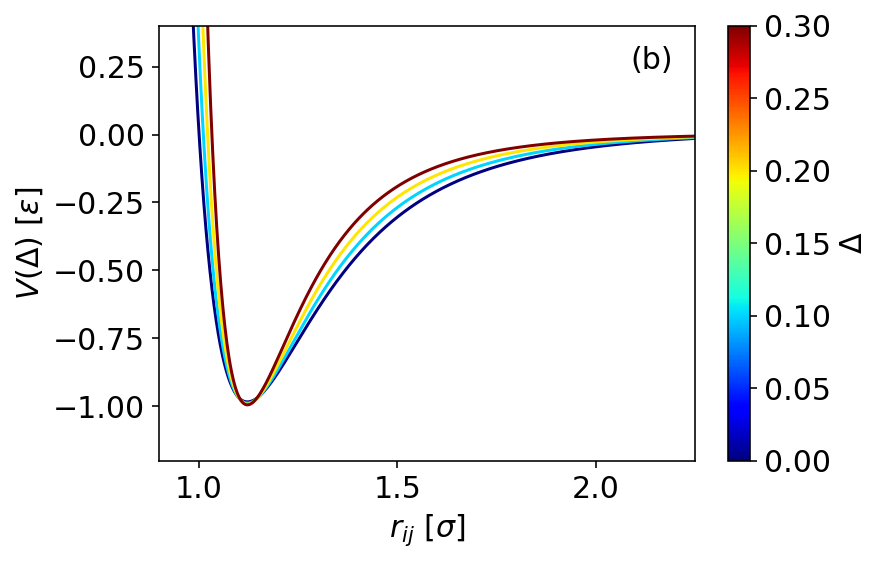

In [76]:
sig = 1.0
cmap = cm.jet
norm = colors.Normalize(vmin=0.0, vmax=0.3)
sm = cm.ScalarMappable(norm, cmap)

for d in np.linspace(0.0, 0.3, 4):
    potential_print_driver(mLJ_shifted,
                           .8*sig, 2.5*sig,
                           kwargs={"epsilon":1.0, "sigma":sig, "delta":d},
                           plot_args={"color":cmap(norm(d))})
plt.ylim(-1.2, .4)
plt.xlim(0.9, 2.25)
plt.colorbar(sm, label=r"$\Delta$")
plt.ylabel(r"$V (\Delta) \ [\epsilon]$")
plt.xlabel(r"$r_{ij}  \ [\sigma]$")

add_inner_plot_text(plt.gca(), "(b)")

## $S_{2,i}$ vs. $S_i$

/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05


([<matplotlib.axis.YTick at 0x7f743a49c9a0>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

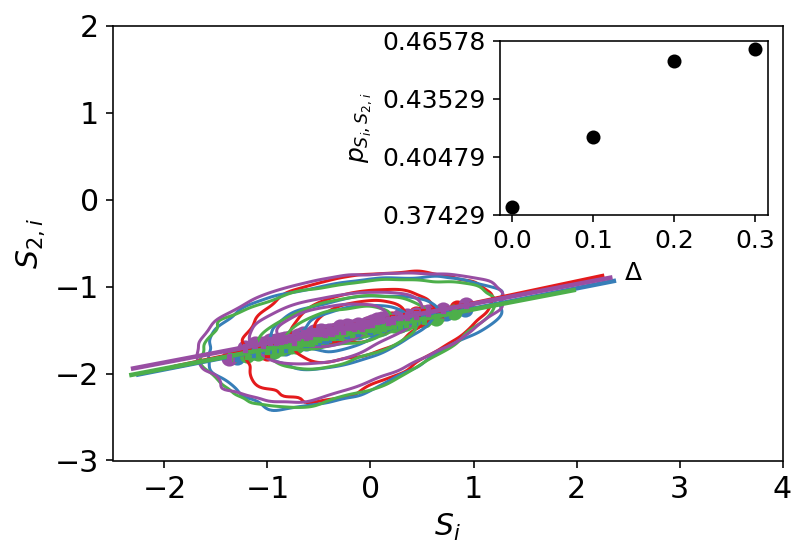

In [46]:

cmap = cm.viridis
norm = colors.Normalize(vmin=0, vmax=0.3)

fig, ax = plt.subplots()

for system, delta, phi, color in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), (0.0, 0.1, 0.2, 0.3), phis, colorz):
    temp = 0.64
    print(system)
    # plt.figure()
    files = filter_chunks(system.glob(f"temp-{temp}_*"), last_chunk)

    df = aggregate_parquet_dfs(files).iloc[:20000]
    df.entropy = df.entropy*phi/2.0 # fix incorrect entropy calculation
    sns.kdeplot(data=df, x="softness", y="entropy", levels=4, color=color)
    sns.regplot(data=df, x="softness", y="entropy", x_bins=40, color=color)
plt.xlabel(r"$S_i$")
plt.ylabel(r"$S_{2,i}$")
plt.xlim(-2.5, 4)
plt.ylim(-3, 2)

ax = inset_axes(ax, width="40%", height="40%")

ax.tick_params(labelsize="small")


for system, delta, phi in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), (0.0, 0.1, 0.2, 0.3), phis):
    temp = 0.64
    # plt.figure()
    files = filter_chunks(system.glob(f"temp-{temp}_*"), last_chunk)

    df = aggregate_parquet_dfs(files)
    df.entropy = df.entropy*phi/2.0 # fix incorrect entropy calculation
    
    plt.plot(delta, scipy.stats.pearsonr(df.softness.values, df.entropy.values)[0], "ok")

#     plt.hist2d(df.softness.values, df.entropy.values, bins=[np.linspace(-1.8, 1.5, 30), np.linspace(-4.2, -1.0, 30)], density=True, cmap=cm.jet);
#     plt.xlabel(r"$S_i$")
#     plt.ylabel(r"$S_{2,i}$")

plt.xlabel(r"$\Delta$", fontsize="small")
plt.ylabel(r"$p_{S_i,S_{2,i}}$", fontsize="small")
ylim = ax.get_ylim()
xlim = ax.get_xlim()
plt.xticks(np.linspace(0.0, 0.3, 4))
plt.yticks(np.linspace(ylim[0], ylim[1], 4))


## $S_{2,i}$ vs. $S_i$ term-by-term

/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 0, '$r_i$')

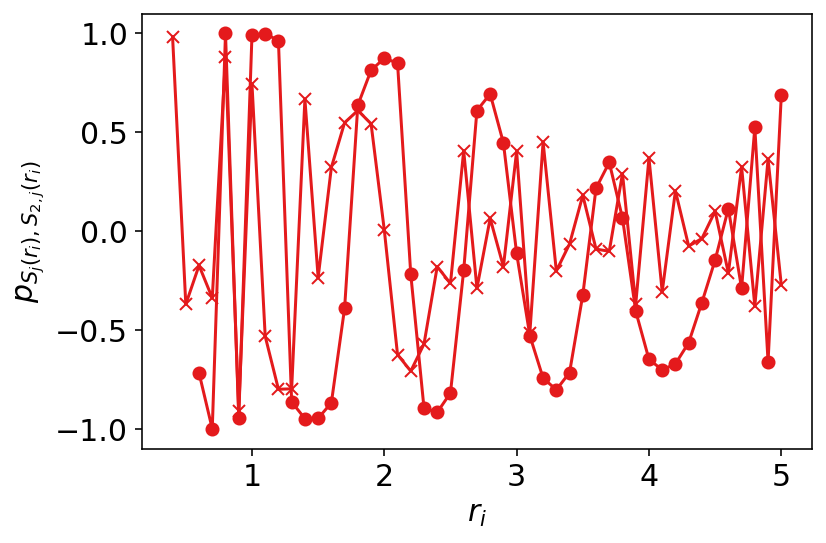

In [297]:
for system, marker, color in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), colorz):
    temp = 0.64
    # plt.figure()
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 95)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    df["arr_soft"] = list(softness_terms_subparts(list(df.Xs.values), pipeline))
    
    g_out, out = fluctuation_entropy_subparts(np.stack(df.Xs.values).astype(np.float64), 1.2, 0.8, 0.2, 100.0)
    
    df["arr_entr"] = list(np.nan_to_num(out))
    
    arr_soft = np.stack(df.arr_soft.values)
    arr_entr = np.stack(df.arr_entr.values)

    for j, marker in zip([0, 1], ["o", "x"]):
        output = []
        for i in range(50):
            result = scipy.stats.pearsonr(arr_soft[:,j+i*2], arr_entr[:,j+i*2])
            output.append(result[0])

        plt.plot(np.linspace(0.1, 5.0, 50), output, marker=marker, color=color)
    break

plt.ylabel(r"$p_{S_j(r_i), S_{2,j}(r_i)}$")
plt.xlabel(r"$r_i$")

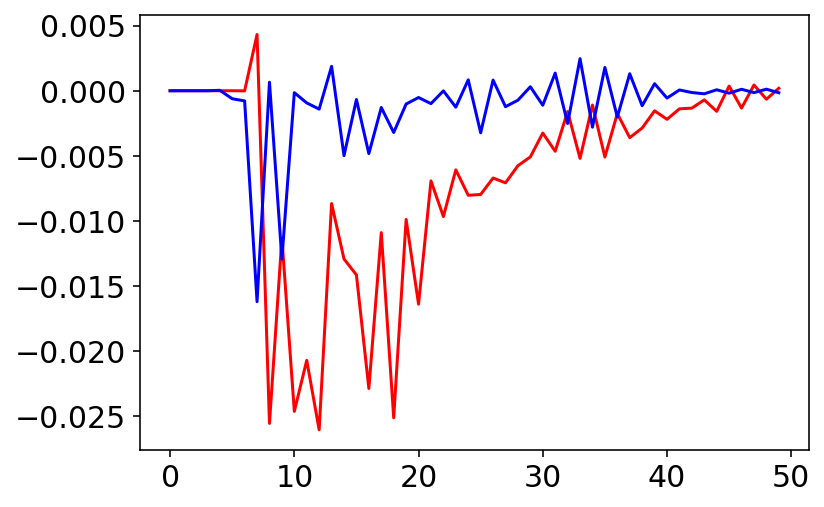

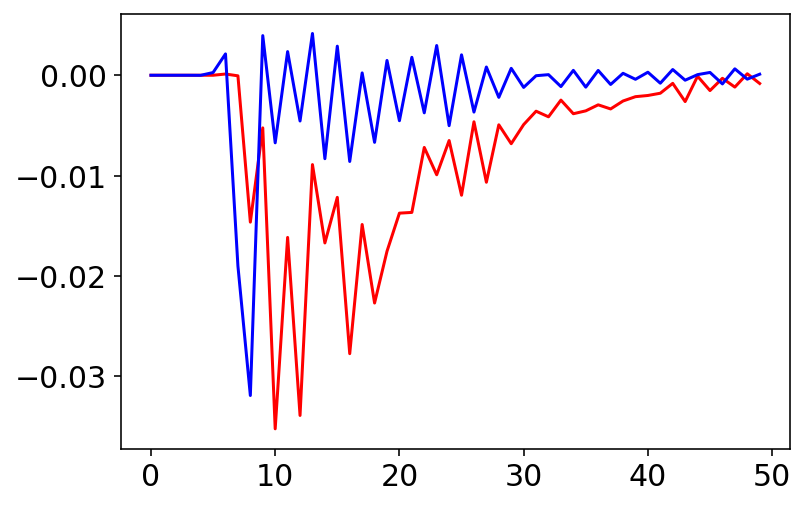

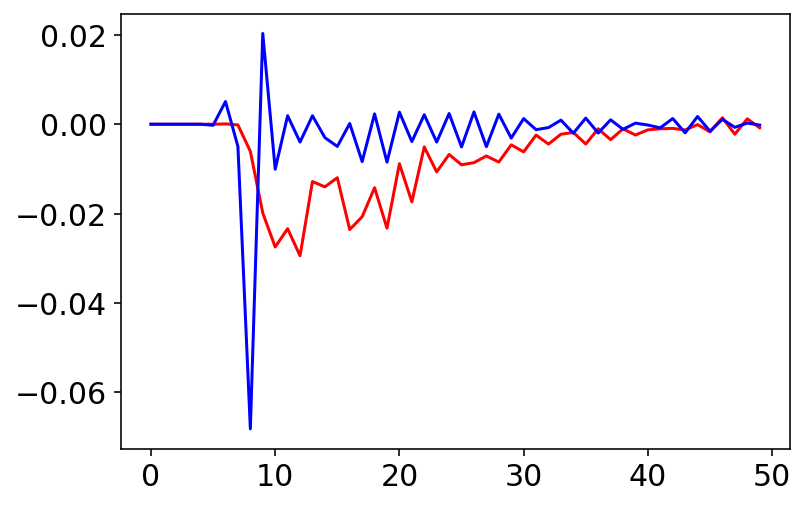

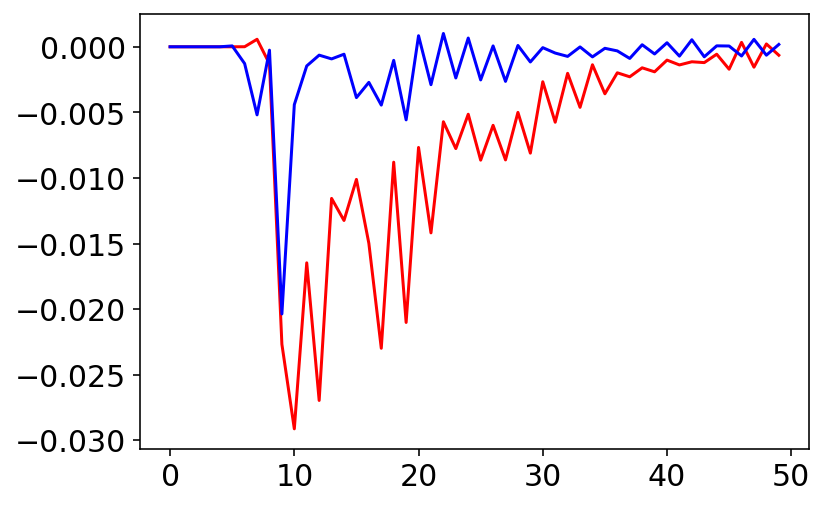

In [287]:
def scaled_weight_functions(pipe):
    r = np.linspace(0.1, 5.0, 50)
    r2 = 4*np.pi*r*r
    weight = pipe[1].coef_[0]*pipe[0].scale_
    A = weight[::2]/r2
    B = weight[1::2]/r2
    return A, B

for system, marker, color in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), colorz):
    temp = 0.64
    plt.figure()
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 95)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    A, B = scaled_weight_functions(pipeline)
    
    plt.plot(A, "r")
    plt.plot(B, "b")

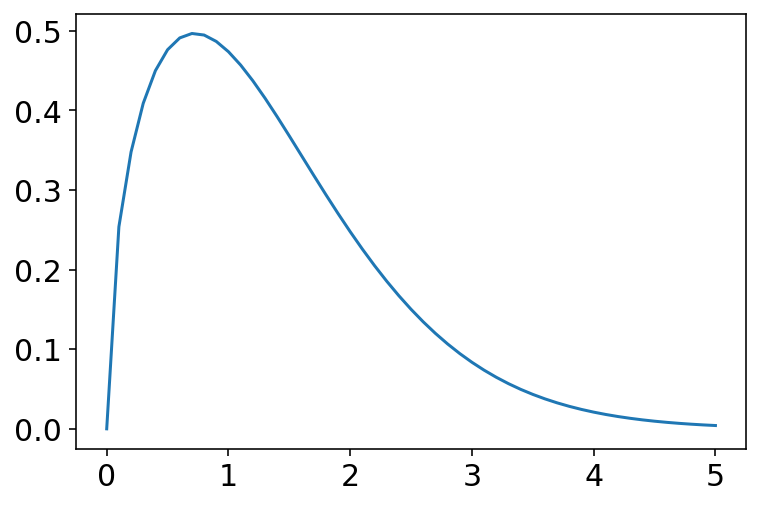

In [280]:
wie_k = 1.5
wie_lam = 1.5
def weibul(x, k, lam):
    return (k/lam)*np.power(x/lam, k-1)*np.exp(-np.power(x/lam, k))

wie_r = np.linspace(0, 5, 51)
plt.plot(wie_r, weibul(wie_r, wie_k, wie_lam))

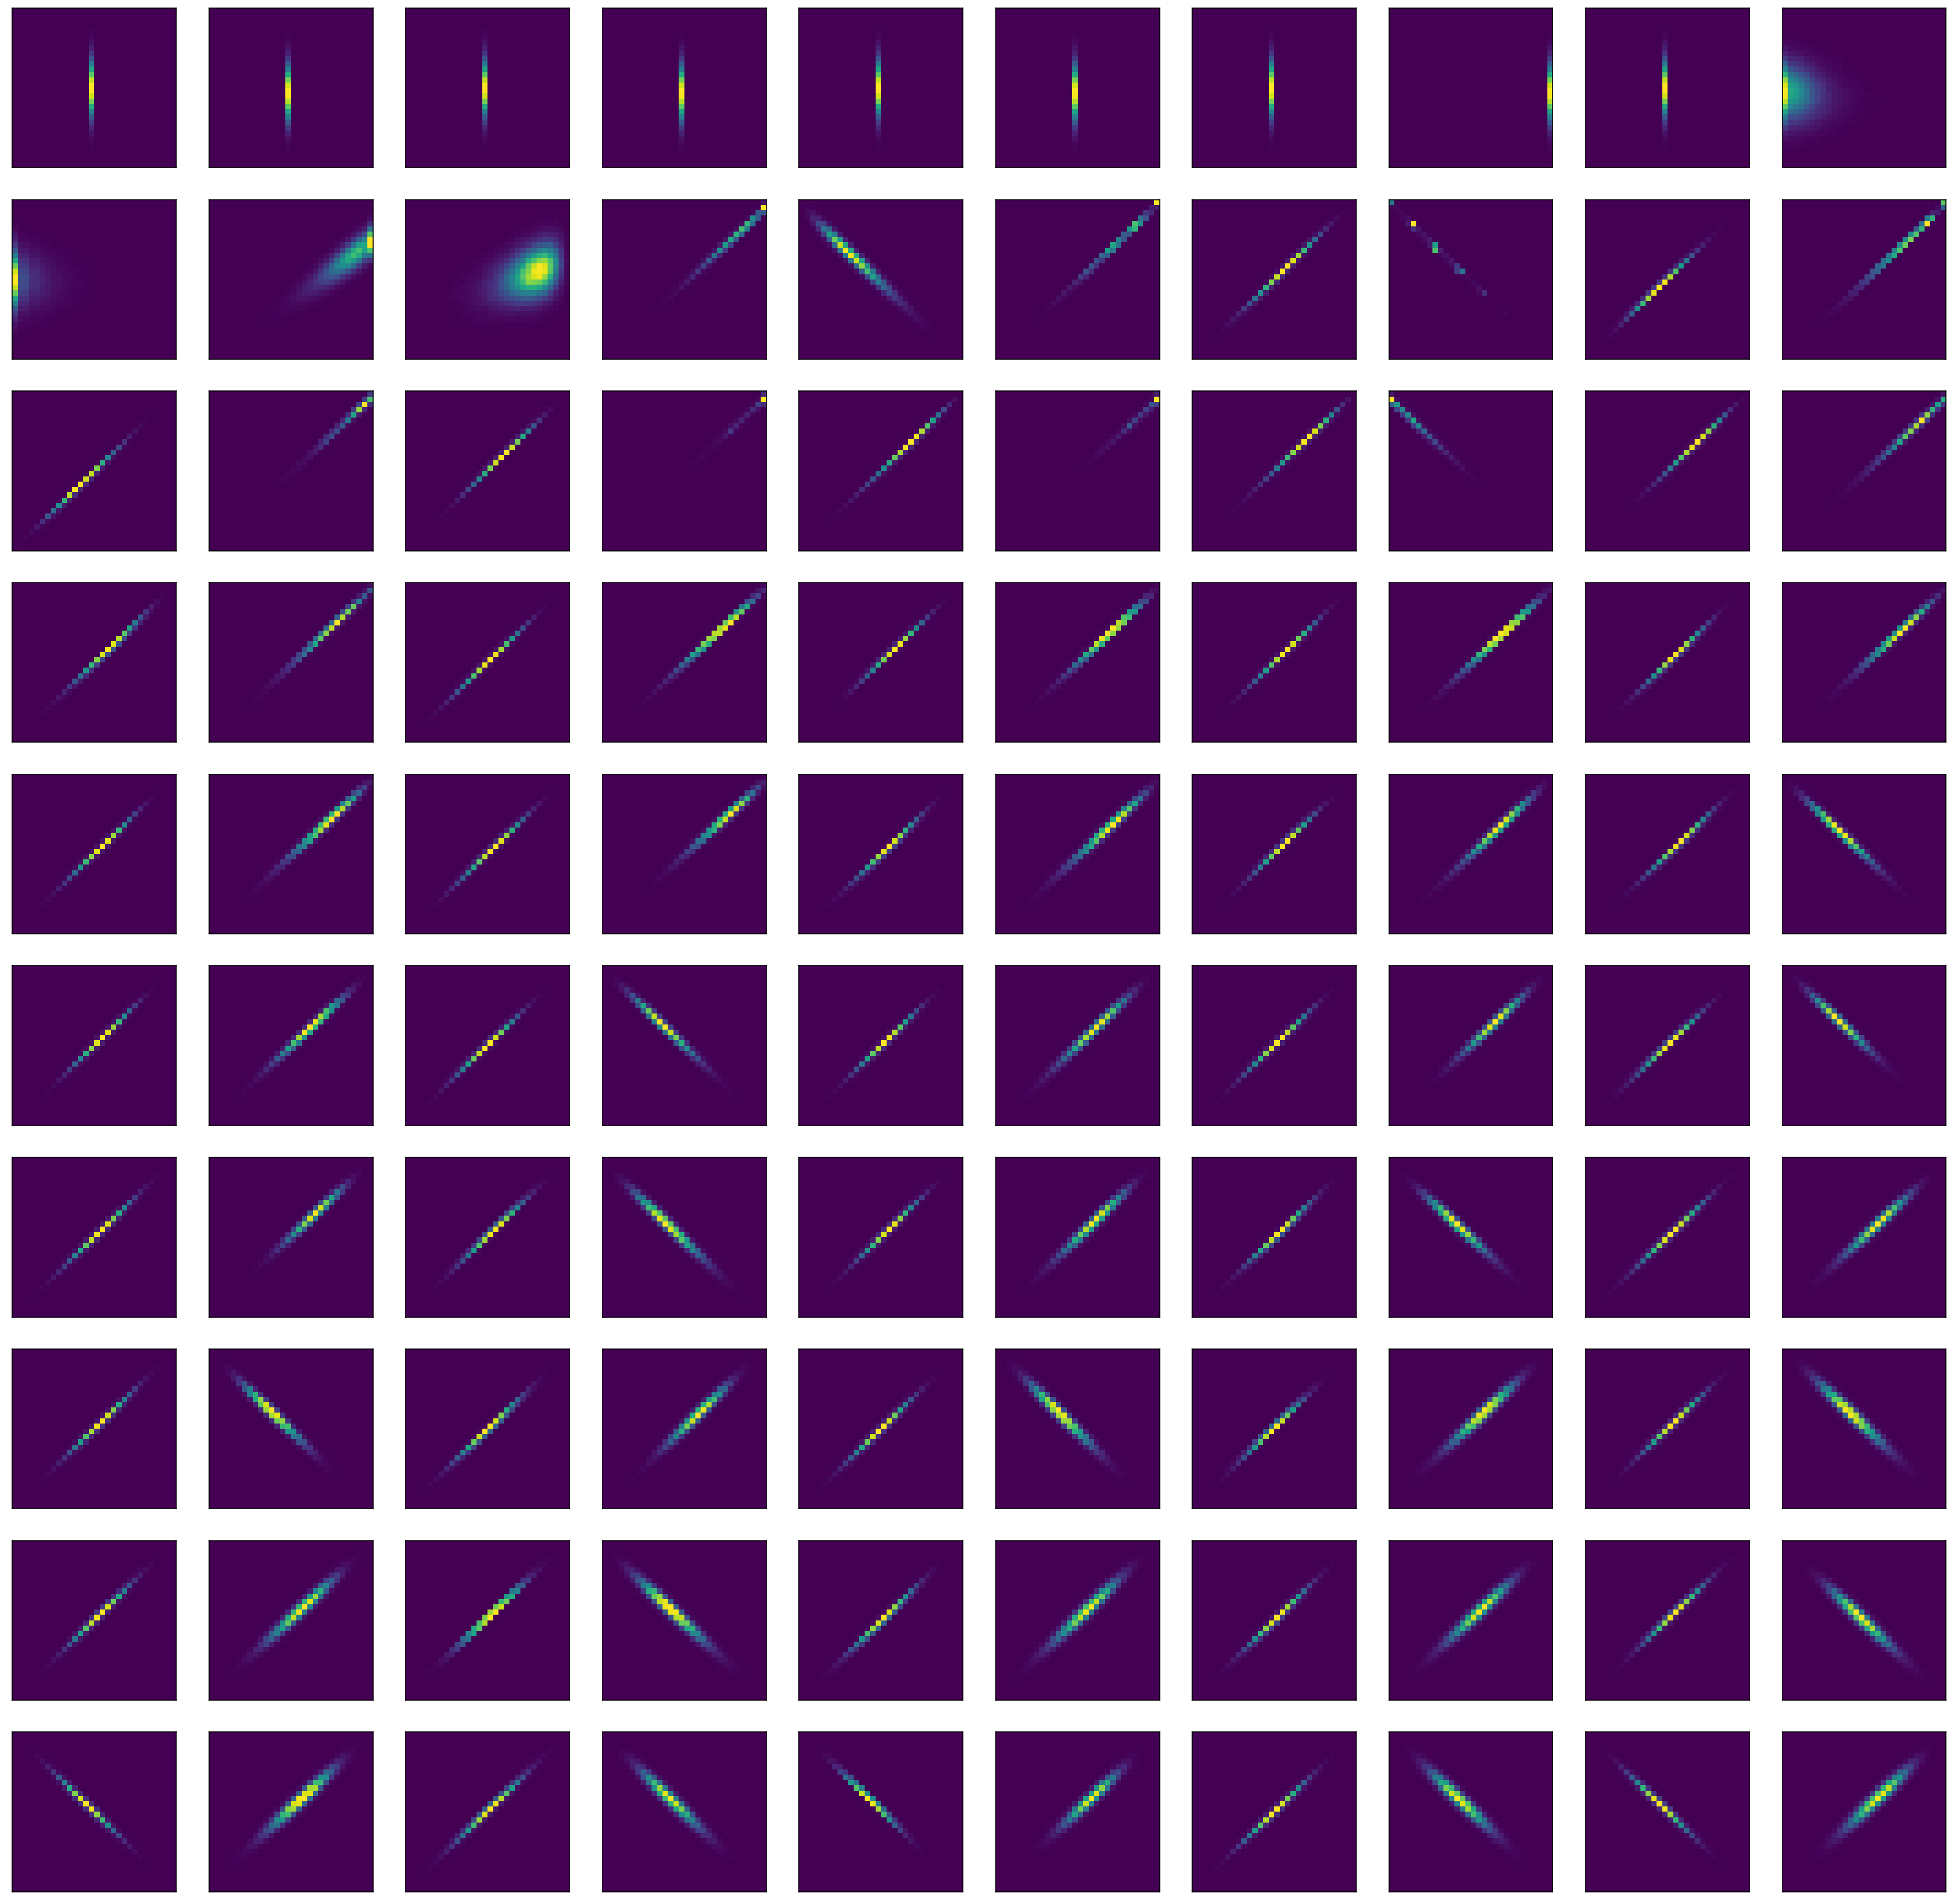

In [245]:
for system, marker, color in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), colorz):
    temp = 0.64
    fig, axs = plt.subplots(10, 10, figsize=(30, 30))
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 95)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    df["arr_soft"] = list(softness_terms_subparts(list(df.Xs.values), pipeline))
    
    g_out, out = fluctuation_entropy_subparts(np.stack(df.Xs.values).astype(np.float64), 1.2, 0.8, 0.2, 5.0)
    
    df["arr_entr"] = list(np.nan_to_num(out))
    
    arr_soft = np.stack(df.arr_soft.values)
    arr_entr = np.stack(df.arr_entr.values)
    output = []

    for i in range(100):
        ax = axs[i//10, i%10]
        plt.sca(ax)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.hist2d(arr_soft[:,i], arr_entr[:,i], bins=30)

    break

# plt.ylabel(r"$p_{S_j(r_i), S_{2,j}(r_i)}$")
# plt.xlabel(r"$r_i$")

/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 0, '$\\tilde{r}_i$')

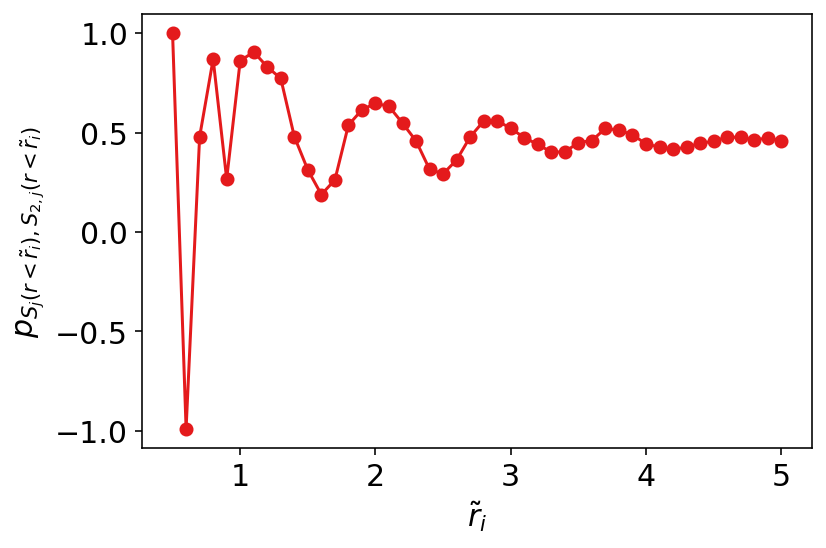

In [443]:
def sli_quad(x, b):
    return x + np.sign(x)*x*x*b
    # return np.sign(x)*(x*np.log(x) - x + 1)
    
r = np.linspace(0.1, 5.0, 50)

for system, marker, color in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), colorz):
    temp = 0.64
    # plt.figure()
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 99)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    df["arr_soft"] = list(softness_terms(list(df.Xs.values), pipeline))
    
    g_out, out = fluctuation_entropy(np.stack(df.Xs.values).astype(np.float64), 1.2, 0.8, 0.2, 100.0)
    
    g1 = (np.mean(g_out[:, 0::2], axis=0) - g_out[:, 0::2])/r
    g2 = (np.mean(g_out[:, 1::2], axis=0) - g_out[:, 1::2])/r
    
    # out2 = sli_quad(g1, 5.0)*0.8 + sli_quad(g2, 0.0)*0.2
    out2 = x[0]*g1 + np.sign(g1)*x[1]*g1*g1 + x[2]*g2 + np.sign(g2)*x[3]*g2*g2
    
    df["arr_entr"] = list(np.nan_to_num(out2))
    
    arr_soft = np.stack(df.arr_soft.values)
    arr_entr = np.stack(df.arr_entr.values)
    output = []

    for i in range(1, 50):
        result = scipy.stats.pearsonr(np.sum(arr_soft[:,:i], axis=1), np.sum(arr_entr[:,:i], axis=1))
        output.append(result[0])

    plt.plot(np.linspace(0.2, 5.0, 49), output, marker=marker, color=color)
    break
    print(result)
plt.ylabel(r"$p_{S_j(r<\tilde{r}_i), S_{2,j}(r<\tilde{r}_i)}$")
plt.xlabel(r"$\tilde{r}_i$")

In [ ]:
output[-1]

0.45873919381979994

In [456]:
def opt_correlation_fluc(x, soft, g1, g2):
    entr_fluc = x[0]*g1 + x[1]*g1*g1 +  x[2]*g1*g1*g1 + x[3]*g2 + x[4]*g2*g2 + x[5]*g2*g2*g2 + x[6]*g1*g2 + x[7]*g1*g1*g2 + x[8]*g2*g2*g1
    result = scipy.stats.pearsonr(np.sum(arr_soft[:,:i], axis=1), np.sum(entr_fluc[:,:i], axis=1))
    
    return 1 - result[0]


In [452]:
from scipy.optimize import minimize

In [455]:
result = minimize(opt_correlation_fluc, np.array([0.8, 0.0, 0.0, 0.2, 0.0, 0.0, 0, 0, 0]), args=(arr_soft, g1, g2), method="BFGS")

In [454]:
result

      fun: 0.5602963280279352
 hess_inv: array([[ 1.54593183e+00, -1.26182761e-01, -6.32510514e+00,
         2.72107800e-02,  8.39053020e-03,  5.64198361e-03],
       [-1.26182761e-01,  1.01375540e+01,  4.88544256e+00,
         2.98585778e-02, -5.15187519e-03,  4.06313138e-03],
       [-6.32510514e+00,  4.88544256e+00,  2.79269115e+02,
         3.15694166e+00,  1.34996427e-01,  2.38617065e-02],
       [ 2.72107800e-02,  2.98585778e-02,  3.15694166e+00,
         1.07020220e-01, -4.44021724e-03, -5.24680990e-03],
       [ 8.39053020e-03, -5.15187519e-03,  1.34996427e-01,
        -4.44021724e-03,  5.71742245e-03,  1.31907148e-03],
       [ 5.64198361e-03,  4.06313138e-03,  2.38617065e-02,
        -5.24680990e-03,  1.31907148e-03,  8.91765283e-04]])
      jac: array([-1.19209290e-07, -7.45058060e-08, -2.98023224e-08,  1.08033419e-06,
       -2.60025263e-06,  9.23871994e-07])
  message: 'Optimization terminated successfully.'
     nfev: 245
      nit: 29
     njev: 35
   status: 0
  success

In [442]:
x = result.x

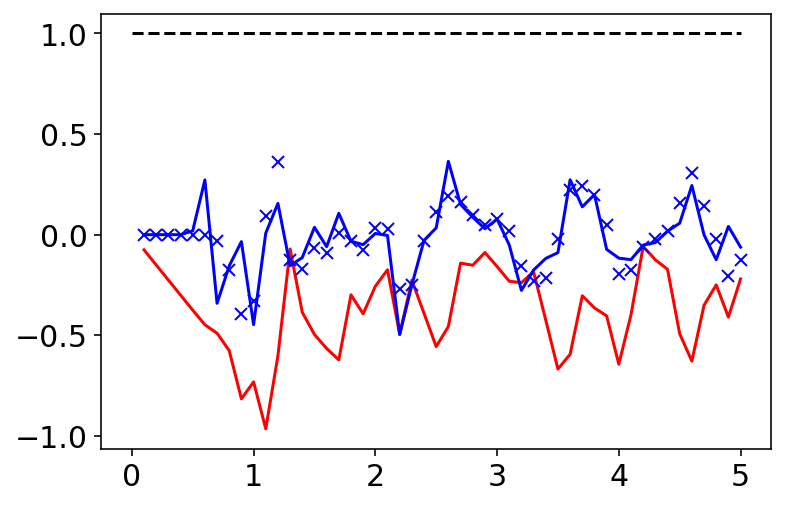

In [398]:
idx = 20
r = np.linspace(0.1, 5.0, 50)
# plt.plot(r, g_out[idx, 0::2])
# plt.plot(r, g_out[idx, 1::2])
plt.plot(r, out[idx], "r")
plt.plot(r, arr_soft[idx], "b")
plt.plot(r, out2[idx] , "xb")
# plt.plot(r, , "xb")
plt.hlines(1.0, 0.0, 5.0, "k", linestyle="--")

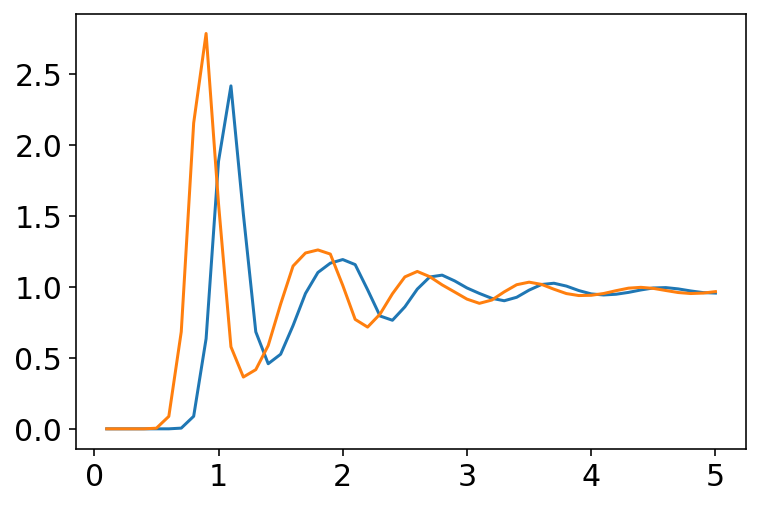

In [347]:
r = np.linspace(0.1, 5.0, 50)
plt.plot(r, np.mean(g_out[:, 0::2], axis=0))
plt.plot(r, np.mean(g_out[:, 1::2], axis=0))

/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  wa

Text(0.5, 0, '$\\tilde{r}_i$')

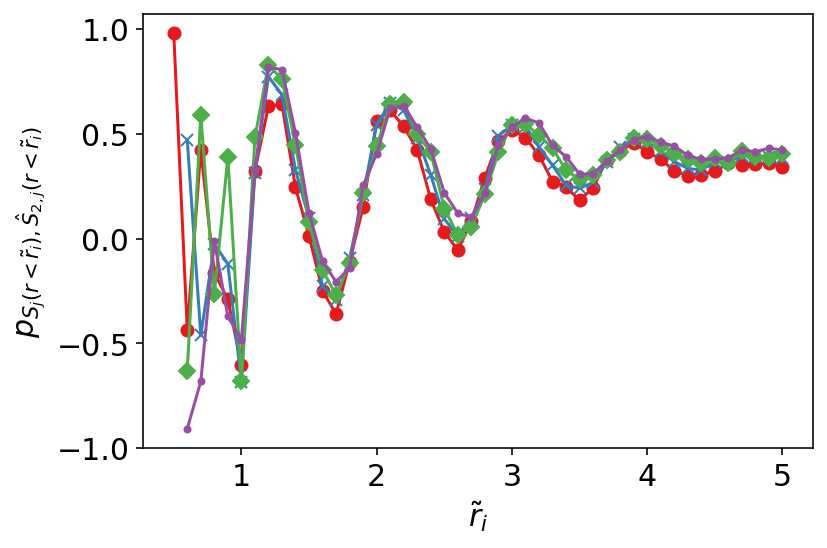

In [350]:
for system, marker, color in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), colorz):
    temp = 0.64
    # plt.figure()
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 95)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    df["arr_soft"] = list(softness_terms(list(df.Xs.values), pipeline))
    
    out = local_s2_terms(np.stack(df.Xs.values).astype(np.float64))
    
    df["arr_entr"] = list(np.nan_to_num(out))
    
    arr_soft = np.stack(df.arr_soft.values)
    arr_entr = np.stack(df.arr_entr.values)
    output = []

    for i in range(1, 50):
        result = scipy.stats.pearsonr(np.sum(arr_soft[:,:i], axis=1), np.sum(arr_entr[:,:i], axis=1))
        output.append(result[0])

    plt.plot(np.linspace(0.2, 5.0, 49), output, marker=marker, color=color)
    # break

plt.ylabel(r"$p_{S_j(r<\tilde{r}_i), \hat{S}_{2,j}(r<\tilde{r}_i)}$")
plt.xlabel(r"$\tilde{r}_i$")

In [351]:
result

(0.42200336349995443, 0.0)

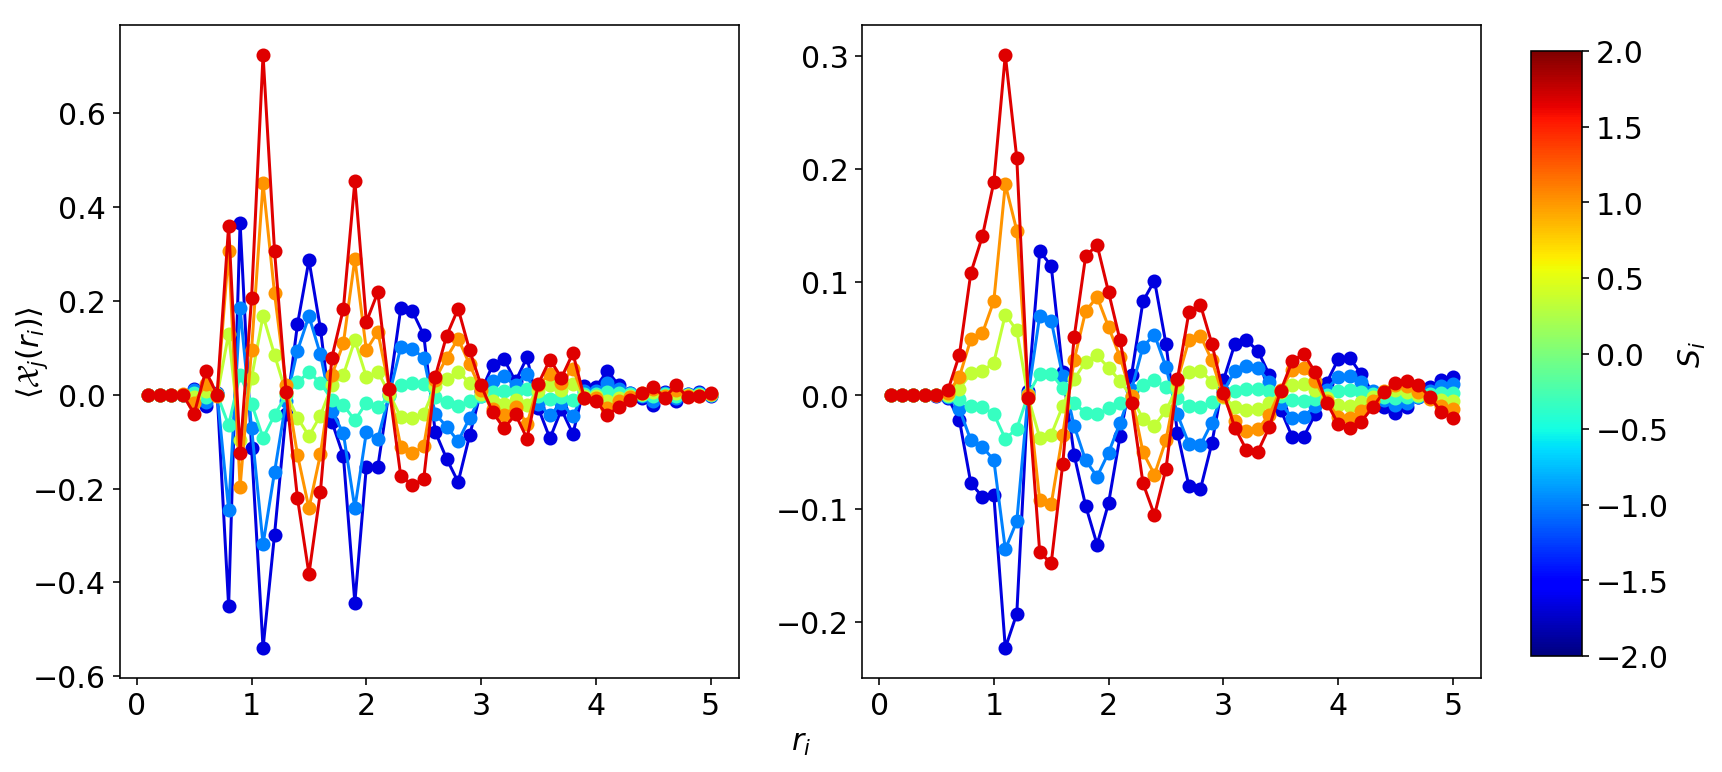

In [346]:


from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable

cuts = np.linspace(-2, 2, 7)
norm = colors.Normalize(vmin=cuts[0], vmax=cuts[-1])
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

for system, marker in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.')):
    temp = 0.64
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)    # The big subplot
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Turn off axis lines and ticks of the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 95)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    df["arr_soft"] = list(softness_terms(list(df.Xs.values), pipeline))
    
    g_out, out = fluctuation_entropy(np.stack(df.Xs.values).astype(np.float64), 1.2, 0.8, 0.1, 1.5)
    
    g1 = np.mean(g_out[:, 0::2], axis=0) - g_out[:, 0::2]
    g2 = np.mean(g_out[:, 1::2], axis=0) - g_out[:, 1::2]
    
    out2 = g1*0.8 + g2*0.2
    
    df["arr_entr"] = list(np.nan_to_num(out2))
    
    df["cuts"] = pd.cut(df["softness"], cuts)
    gpby = df.groupby("cuts")
    
    arr_soft = np.stack(df.arr_soft.values)
    arr_entr = np.stack(df.arr_entr.values)

    arr_soft_mean = np.mean(arr_soft, axis=0)

    arr_entr_mean = np.mean(arr_entr, axis=0)
    
    for (soft, df) in gpby:
        # arr_soft = preprocessing.normalize(np.stack(df.arr_soft.values), axis=1)
        # arr_entr = preprocessing.normalize(np.stack(df.arr_entr.values), axis=1)
        arr_soft = np.stack(df.arr_soft.values)
        arr_entr = np.stack(df.arr_entr.values)
        
        arr_soft = np.mean(arr_soft, axis=0) - arr_soft_mean
        
        arr_entr = np.mean(arr_entr, axis=0) - arr_entr_mean

        ax1.plot(np.linspace(0.1, 5.0, 50), arr_soft, marker=marker, color=cmap(norm(soft.mid)))
        ax2.plot(np.linspace(0.1, 5.0, 50), arr_entr, marker=marker, color=cmap(norm(soft.mid)))
    # break

    ax.set_ylabel(r"$\langle{\mathcal{X}_j(r_i)}\rangle$")
    ax.set_xlabel(r"$r_i$")
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.0)
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
    # fig.colorbar(sm, cax=cax)
    fig.colorbar(sm, cax=cax, orientation='vertical', label=r"$S_i$")
    break


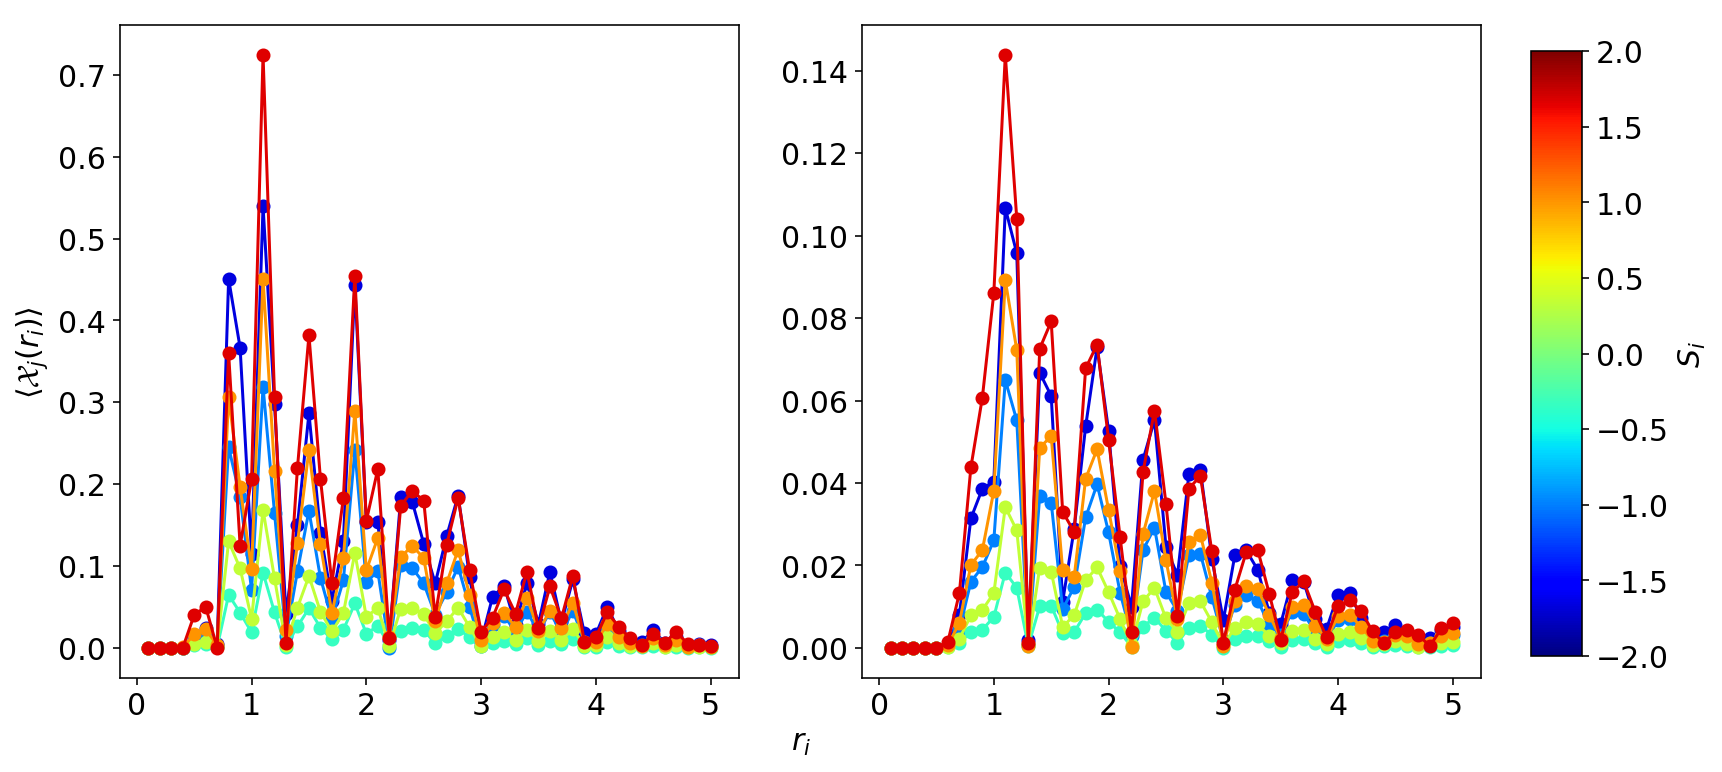

In [263]:


from sklearn import preprocessing
from mpl_toolkits.axes_grid1 import make_axes_locatable

cuts = np.linspace(-2, 2, 7)
norm = colors.Normalize(vmin=cuts[0], vmax=cuts[-1])
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

for system, marker in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.')):
    temp = 0.64
    fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)    # The big subplot
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # Turn off axis lines and ticks of the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 95)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    df["arr_soft"] = list(softness_terms(list(df.Xs.values), pipeline))
    
    g_out, out = fluctuation_entropy(np.stack(df.Xs.values).astype(np.float64), 1.2, 0.8, 0.2, 2.0)
    
    df["arr_entr"] = list(np.nan_to_num(out))
    
    df["cuts"] = pd.cut(df["softness"], cuts)
    gpby = df.groupby("cuts")
    
    arr_soft = np.stack(df.arr_soft.values)
    arr_entr = np.stack(df.arr_entr.values)

    arr_soft_mean = np.mean(arr_soft, axis=0)

    arr_entr_mean = np.mean(arr_entr, axis=0)
    
    for (soft, df) in gpby:
        # arr_soft = preprocessing.normalize(np.stack(df.arr_soft.values), axis=1)
        # arr_entr = preprocessing.normalize(np.stack(df.arr_entr.values), axis=1)
        arr_soft = np.stack(df.arr_soft.values)
        arr_entr = np.stack(df.arr_entr.values)
        
        arr_soft = np.mean(arr_soft, axis=0) - arr_soft_mean
        
        arr_entr = np.mean(arr_entr, axis=0) - arr_entr_mean

        ax1.plot(np.linspace(0.1, 5.0, 50), np.abs(arr_soft), marker=marker, color=cmap(norm(soft.mid)))
        ax2.plot(np.linspace(0.1, 5.0, 50), np.abs(arr_entr), marker=marker, color=cmap(norm(soft.mid)))
    # break

    ax.set_ylabel(r"$\langle{\mathcal{X}_j(r_i)}\rangle$")
    ax.set_xlabel(r"$r_i$")
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.0)
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
    # fig.colorbar(sm, cax=cax)
    fig.colorbar(sm, cax=cax, orientation='vertical', label=r"$S_i$")
    break


In [ ]:
# We are going to aggregate all of the term subplots into one large 4x4 plot

cuts = np.linspace(-2, 2, 7)
norm = colors.Normalize(vmin=cuts[0], vmax=cuts[-1])
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(14,6))
    ax = fig.add_subplot(111)    # The big subplot
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)


for system, marker in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.')):
    temp = 0.64

    # Turn off axis lines and ticks of the big subplot
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 90)

    df = aggregate_parquet_dfs(files, ["Xs", "softness"], allow_null=False)

    pipeline = get_softness_pipeline(system)
    
    df["arr_soft"] = list(softness_terms(list(df.Xs.values), pipeline))
    
    out = local_s2_terms(np.stack(df.Xs.values).astype(np.float64))
    
    df["arr_entr"] = list(np.nan_to_num(out))
    
    df["cuts"] = pd.cut(df["softness"], cuts)
    gpby = df.groupby("cuts")
    
    arr_soft = np.stack(df.arr_soft.values)
    arr_entr = np.stack(df.arr_entr.values)

    arr_soft_mean = np.mean(arr_soft, axis=0)

    arr_entr_mean = np.mean(arr_entr, axis=0)
    
    for (soft, df) in gpby:
        # arr_soft = preprocessing.normalize(np.stack(df.arr_soft.values), axis=1)
        # arr_entr = preprocessing.normalize(np.stack(df.arr_entr.values), axis=1)
        arr_soft = np.stack(df.arr_soft.values)
        arr_entr = np.stack(df.arr_entr.values)
        
        arr_soft = np.mean(arr_soft, axis=0) - arr_soft_mean
        
        arr_entr = np.mean(arr_entr, axis=0) - arr_entr_mean

        ax1.plot(np.linspace(0.1, 5.0, 50), arr_soft, marker=marker, color=cmap(norm(soft.mid)))
        ax2.plot(np.linspace(0.1, 5.0, 50), arr_entr, marker=marker, color=cmap(norm(soft.mid)))
    # break

    ax.set_ylabel(r"$\langle{\mathcal{X}_j(r_i)}\rangle$")
    ax.set_xlabel(r"$r_i$")
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes('right', size='5%', pad=0.0)
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
    # fig.colorbar(sm, cax=cax)
    fig.colorbar(sm, cax=cax, orientation='vertical', label=r"$S_i$")
    break


## $g(r)$ plots

/home/igraham/Data/funnel-cake/entr_soft_pub/final/excess_entropy/run1/pair-KA_LJ_phi-1.2


/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/schmeud/statics/entropy/_entropy.py:19: RuntimeWarning: divide by zero encountered in log
  return -trapezoid(np.nan_to_num((g*np.log(g) - g + 1)*r), r)
/mnt/rrio1/home/igraham/Projects/work/funnel-cake/.venv/lib/python3.8/site-packages/schmeud/statics/entropy/_entropy.py:19: RuntimeWarning: invalid value encountered in multiply
  return -trapezoid(np.nan_to_num((g*np.log(g) - g + 1)*r), r)


Text(0.5, 0, 'S')

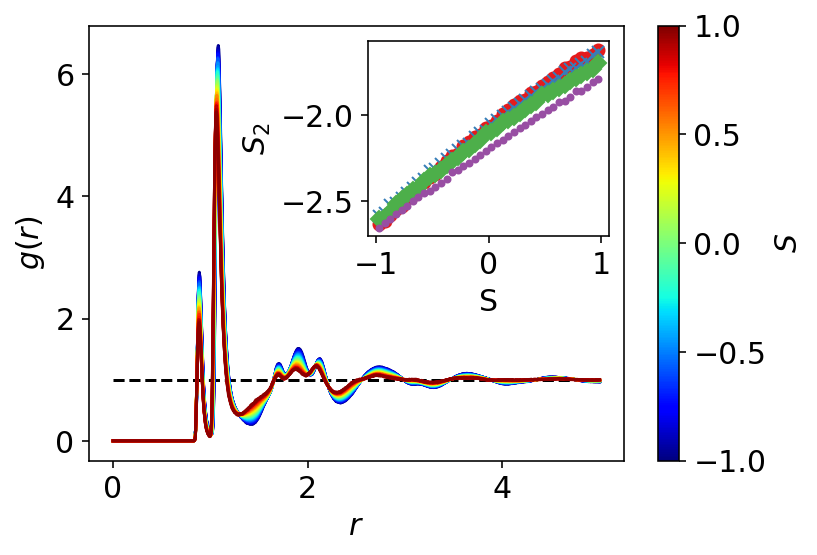

In [ ]:
r = np.linspace(0, 5.0, 1000, endpoint=False)
r += (r[1] - r[0])/2
dr = r[1] - r[0]

norm = colors.Normalize(vmin=-1, vmax=1)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots()

for system, marker in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/excess_entropy/*/*")), ('o', 'x', 'D', '.')):
    temp = 0.64
    phi = pair_phi[system.parts[-1]]
    if not temp_ok(system, temp, min_temp):
        continue
    print(system)
    plt.hlines(1.0, 0, 5, linestyle='--', color="k")
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 40)
    rdf = aggregate_rdf_pickles(files, fix_phi=phi)
    for soft, g in rdf.items():
        res = np.sum(np.square(r)*dr*g*3)/(r[-1]**3)
#         print(soft, res)
        ax.plot(r, g/res, color=cmap(norm(soft)))
        
    
    plt.ylabel(r"$g(r)$")
    plt.xlabel(r"$r$")
    plt.colorbar(sm, label=r"$S$")
    break
    
ax = inset_axes(ax, width="45%", height="45%")
    
for system, marker, color, phi in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/excess_entropy/*/*")), ('o', 'x', 'D', '.'), colorz, phis):
    temp = 0.64
    phi = pair_phi[system.parts[-1]]
#         print(phi)
    if not temp_ok(system, temp, min_temp):
        continue
    files = filter_chunks(system.glob(f"temp-{temp}_*"), 40)
    rdf = aggregate_rdf_pickles(files, fix_phi=phi)

    s2s = []
    softs = []

    for soft, g in rdf.items():
#         g = gaussian_filter1d(g, 20)
        res = np.sum(np.square(r)*dr*g*3)/(r[-1]**3)
        s2 = phi*np.pi*s_2_trap(r, g/res)
        plt.plot(soft, s2, marker=marker, color=color)
        softs.append(soft)
        s2s.append(s2)

    # soft_calc_s2s.append((softs, s2s))

plt.ylabel(r"$S_2$")
plt.xlabel(r"S")

/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05


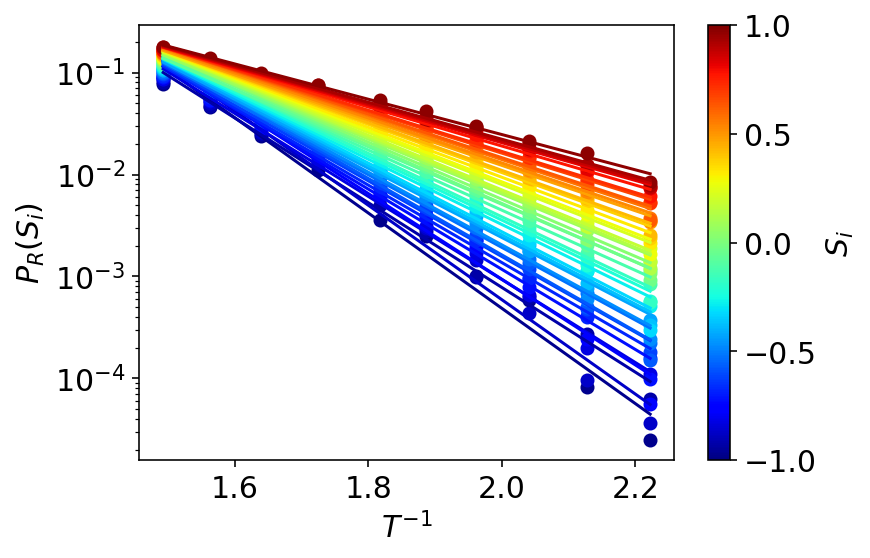

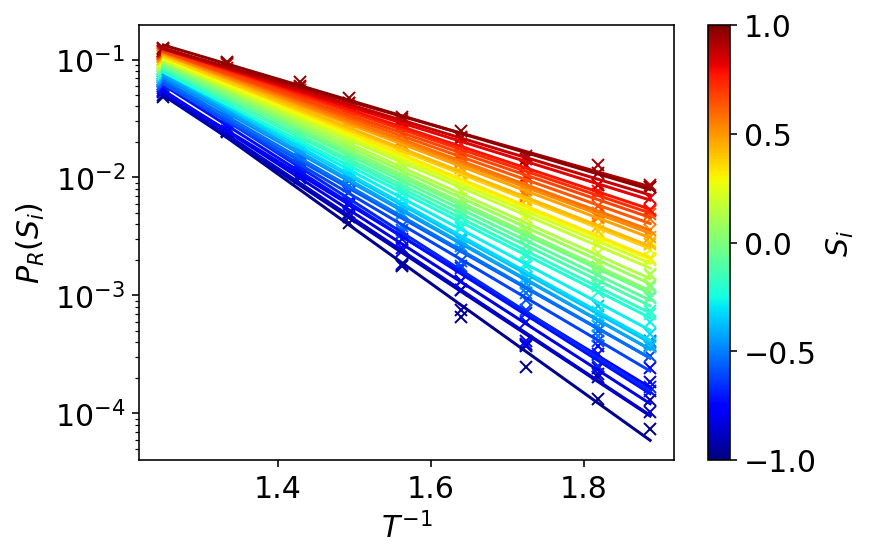

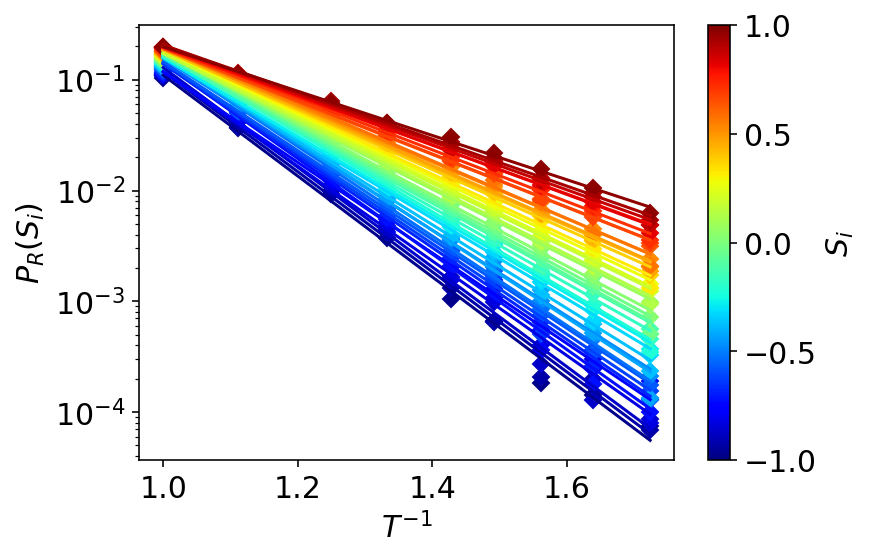

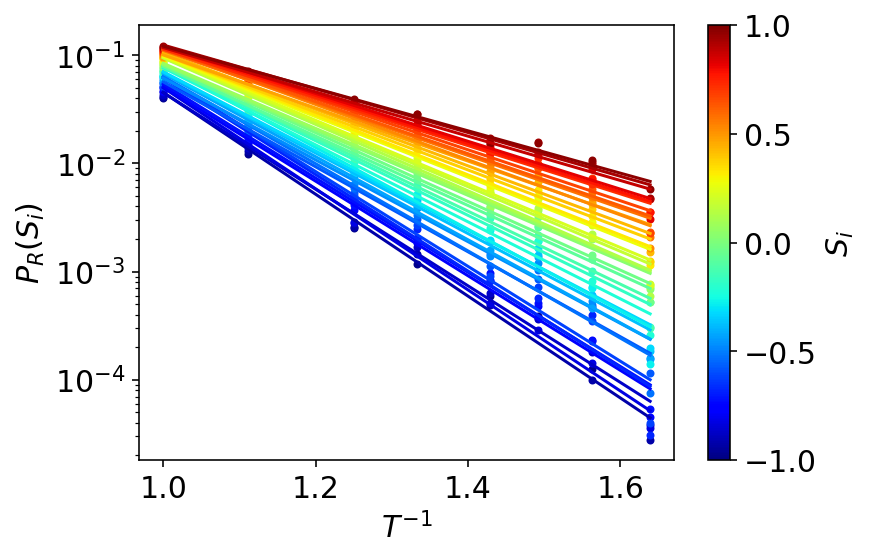

In [ ]:


q_min = -1.0
q_max = 1.0

cuts = np.linspace(-1,1,21)        
norm = colors.Normalize(vmin=q_min, vmax=q_max)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

fit_output_data = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for system, marker in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.')):
        print(str(system))
        plt.figure()

        fit_data = defaultdict(list)
        coefs = []

        for temp in temps:
            if not temp_ok(system, temp, min_temp):
                continue
            if not max_temp_ok(system, temp, max_fit_temp):
                continue
            files = filter_chunks(system.glob(f"temp-{temp}_*"), 80)

            df = aggregate_parquet_dfs(files)
            df["cuts"] = pd.cut(df["softness"], cuts)

            gpby = df.groupby("cuts")

            new_df = gpby["rearrang"].mean()

            for i, rearrang in new_df.iteritems():
                plt.plot(1/temp, rearrang, marker, color=cmap(norm(i.mid)))
                fit_data[i.mid].append([1/temp, rearrang])
                
        fit_output_data.append(fit_data)

        for j, d in fit_data.items():
            d = np.array(d)
            coef = np.polyfit(d[:,0], np.log(d[:,1]), 1)
            tcoef = [j]
            tcoef.extend(list(coef))
            coefs.append(tcoef)
            y = np.exp(coef[1])*np.exp(coef[0]*d[:,0])
            plt.plot(d[:,0], y, color=cmap(norm(j)))

        plt.yscale('log')
        plt.ylabel(r"$P_R(S_{i})$")
        plt.xlabel(r"$T^{-1}$")
        plt.colorbar(sm, label=r"$S_{i}$")

/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05


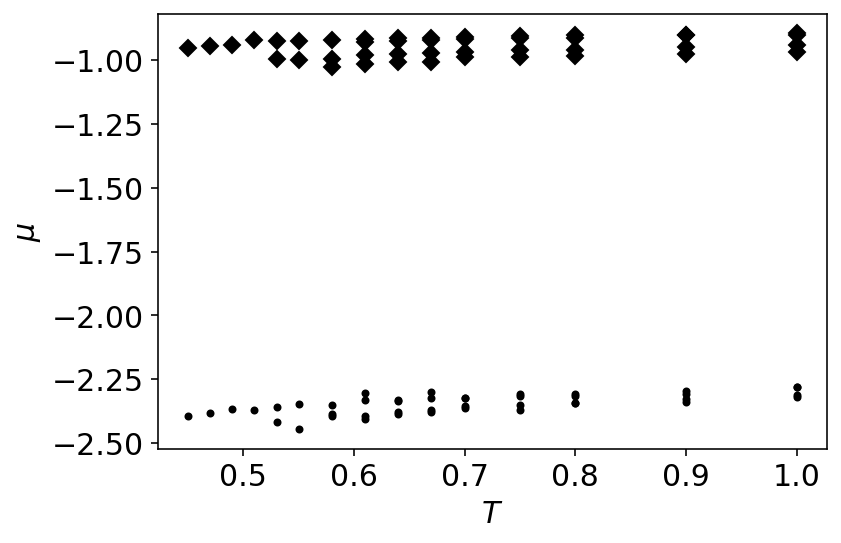

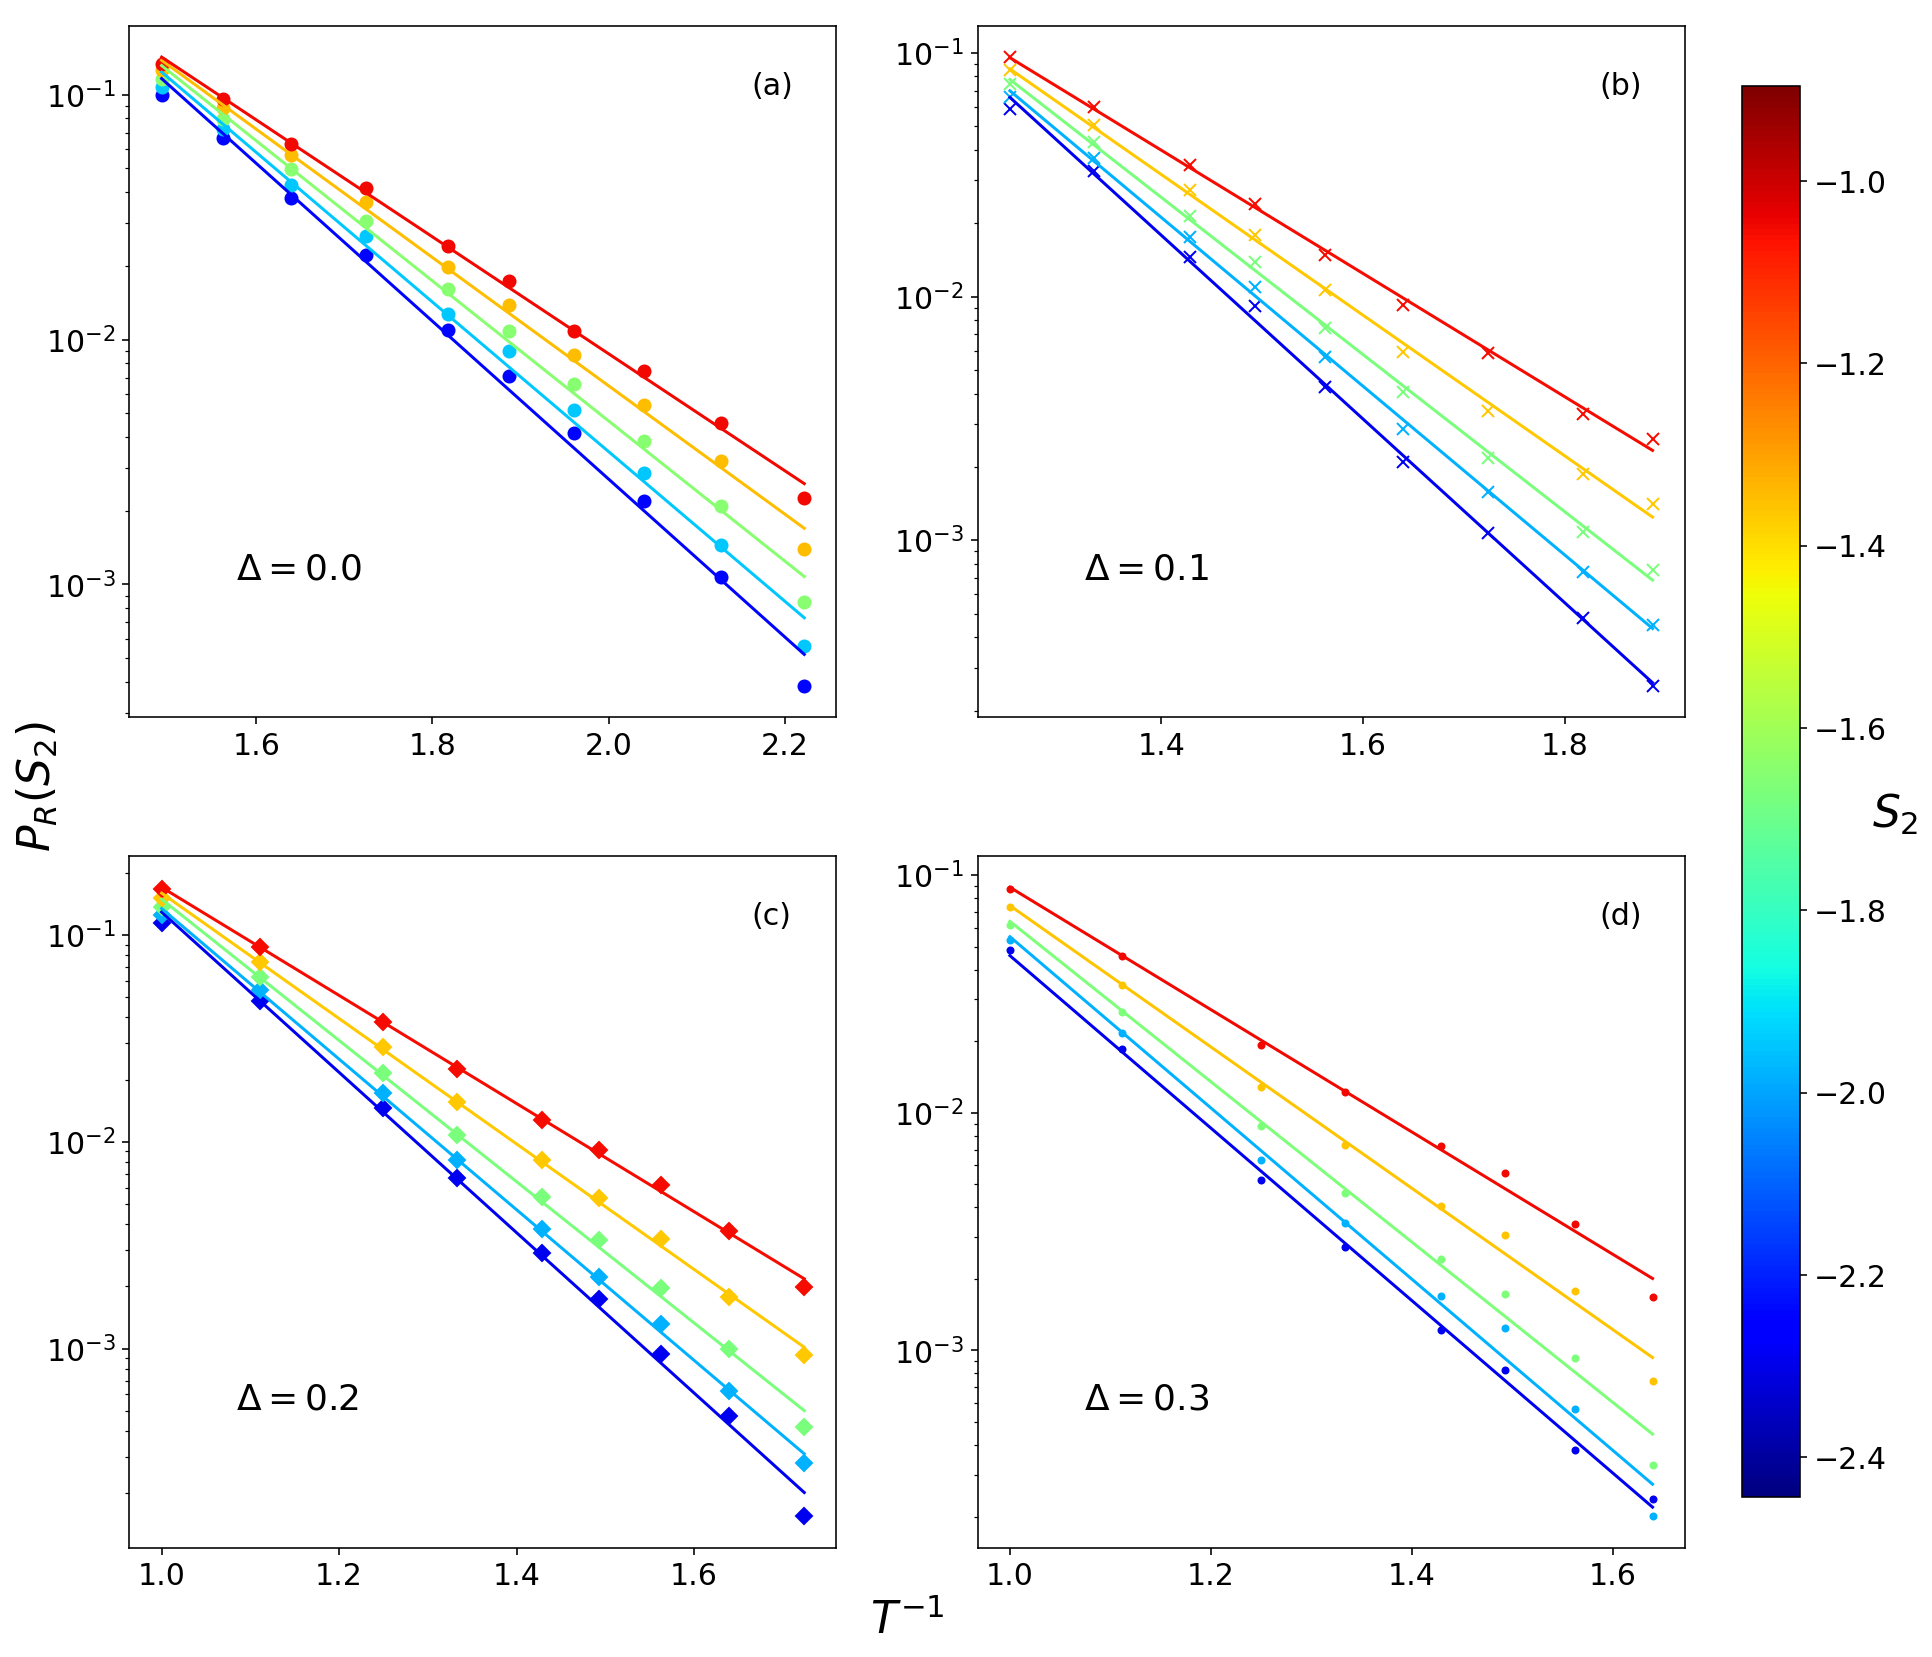

In [38]:
q_min = np.inf
q_max = np.NINF
sq_min = np.inf
sq_max = np.NINF

q_data = {}

for system, marker, phi in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), phis):
    print(str(system))
    for temp in temps:
        if not temp_ok(system, temp, min_temp):
            continue
        files = filter_chunks(system.glob(f"temp-{temp}_*"), last_chunk)

        df = aggregate_parquet_dfs(files)
        
        qcut = pd.qcut(df.entropy.values*phi/2.0, 100).categories
        per5min = qcut[0].right
        per5max = qcut[-1].left
        q_min = min(q_min, per5min)
        q_max = max(q_max, per5max)
        sq_min = min(sq_min, per5min)
        sq_max = max(sq_max, per5max)
        
        
        
        plt.plot(temp, per5min, ".k")
        plt.plot(temp, per5max, 'Dk')
    q_data[system] = (sq_min, sq_max)
    
q_min_all = q_min
q_max_all = q_max

plt.xlabel(r"$T$")
plt.ylabel(r"$\mu$")
q_min, q_max

# make nice 4 bit plots

from collections import defaultdict

# q_min = -1.0
# q_max = 1.0

        
norm = colors.Normalize(vmin=q_min_all, vmax=q_max_all)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(16,14))
plt.ylabel(r"$P_R(S_2)$", fontsize=22)
plt.xlabel(r"$T^{-1}$", fontsize=22)
# ax0 = fig.add_subplot(111)    # The big subplot
ax0 = plt.gca()
ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')
ax0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs = [ax1, ax2, ax3, ax4]

sub_labels = ["(a)", "(b)", "(c)", "(d)"]
deltas = [0.0, 0.1, 0.2, 0.3]


fit_output_data = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for system, marker, ax, sub_label, delta, phi in zip(
                sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")),
                ('o', 'x', 'D', '.'),
                axs,
                sub_labels,
                deltas,
                phis
            ):
        print(str(system))

        fit_data = defaultdict(list)
        coefs = []

        (qmin, qmax) = q_data[system]
        
        for temp in temps:
            if not temp_ok(system, temp, min_temp):
                continue
            if not max_temp_ok(system, temp, max_fit_temp):
                continue
                
            
                
            cuts = np.linspace(qmin, qmax,6)
            files = filter_chunks(system.glob(f"temp-{temp}_*"), 80)

            df = aggregate_parquet_dfs(files)
            df.entropy = df.entropy*phi/2.0
            df["cuts"] = pd.cut(df.entropy, cuts)

            gpby = df.groupby("cuts")

            new_df = gpby["rearrang"].mean()

            for i, rearrang in new_df.iteritems():
                ax.plot(1/temp, rearrang, marker, color=cmap(norm(i.mid)))
                fit_data[i.mid].append([1/temp, rearrang])
                
        fit_output_data.append(fit_data)

        for j, d in fit_data.items():
            d = np.array(d)
            coef = np.polyfit(d[:,0], np.log(d[:,1]), 1)
            tcoef = [j]
            tcoef.extend(list(coef))
            coefs.append(tcoef)
            y = np.exp(coef[1])*np.exp(coef[0]*d[:,0])
            ax.plot(d[:,0], y, color=cmap(norm(j)))
        ax.set_yscale('log')
        add_inner_plot_text(ax, sub_label)
        add_inner_plot_text(ax, fr"$\Delta={delta}$", x=0.15, y=0.2, fontsize="large")

# plt.yscale('log')

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(label=r"$S_2$", fontsize=22, rotation=0)

/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05


(-1.715, 1.353)

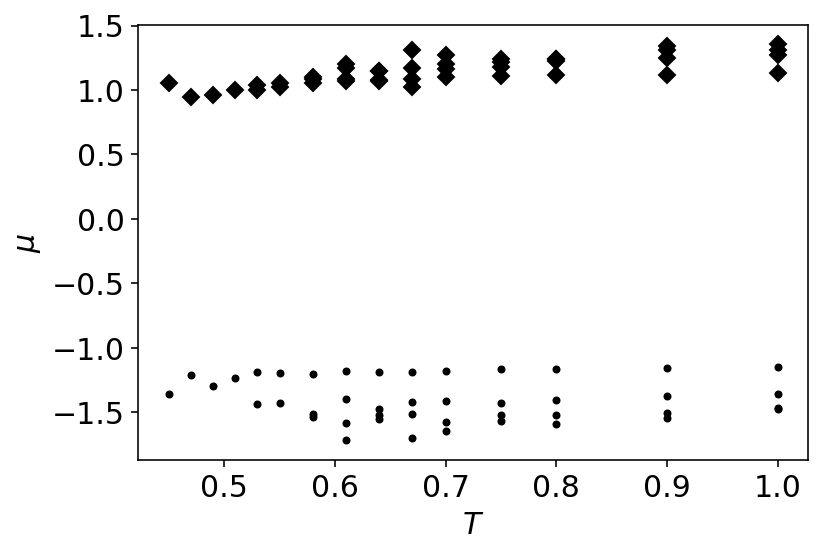

In [77]:
q_min = np.inf
q_max = np.NINF
sq_min = np.inf
sq_max = np.NINF

q_data = {}

for system, marker in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.')):
    print(str(system))
    for temp in temps:
        if not temp_ok(system, temp, min_temp):
            continue
        files = filter_chunks(system.glob(f"temp-{temp}_*"), last_chunk)

        df = aggregate_parquet_dfs(files)
        
        qcut = pd.qcut(df.softness.values, 100).categories
        per5min = qcut[0].right
        per5max = qcut[-1].left
        q_min = min(q_min, per5min)
        q_max = max(q_max, per5max)
        sq_min = min(sq_min, per5min)
        sq_max = max(sq_max, per5max)
        
        
        
        plt.plot(temp, per5min, ".k")
        plt.plot(temp, per5max, 'Dk')
    q_data[system] = (sq_min, sq_max)
    
q_min_all = q_min
q_max_all = q_max
        
plt.xlabel(r"$T$")
plt.ylabel(r"$\mu$")
q_min, q_max

/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05


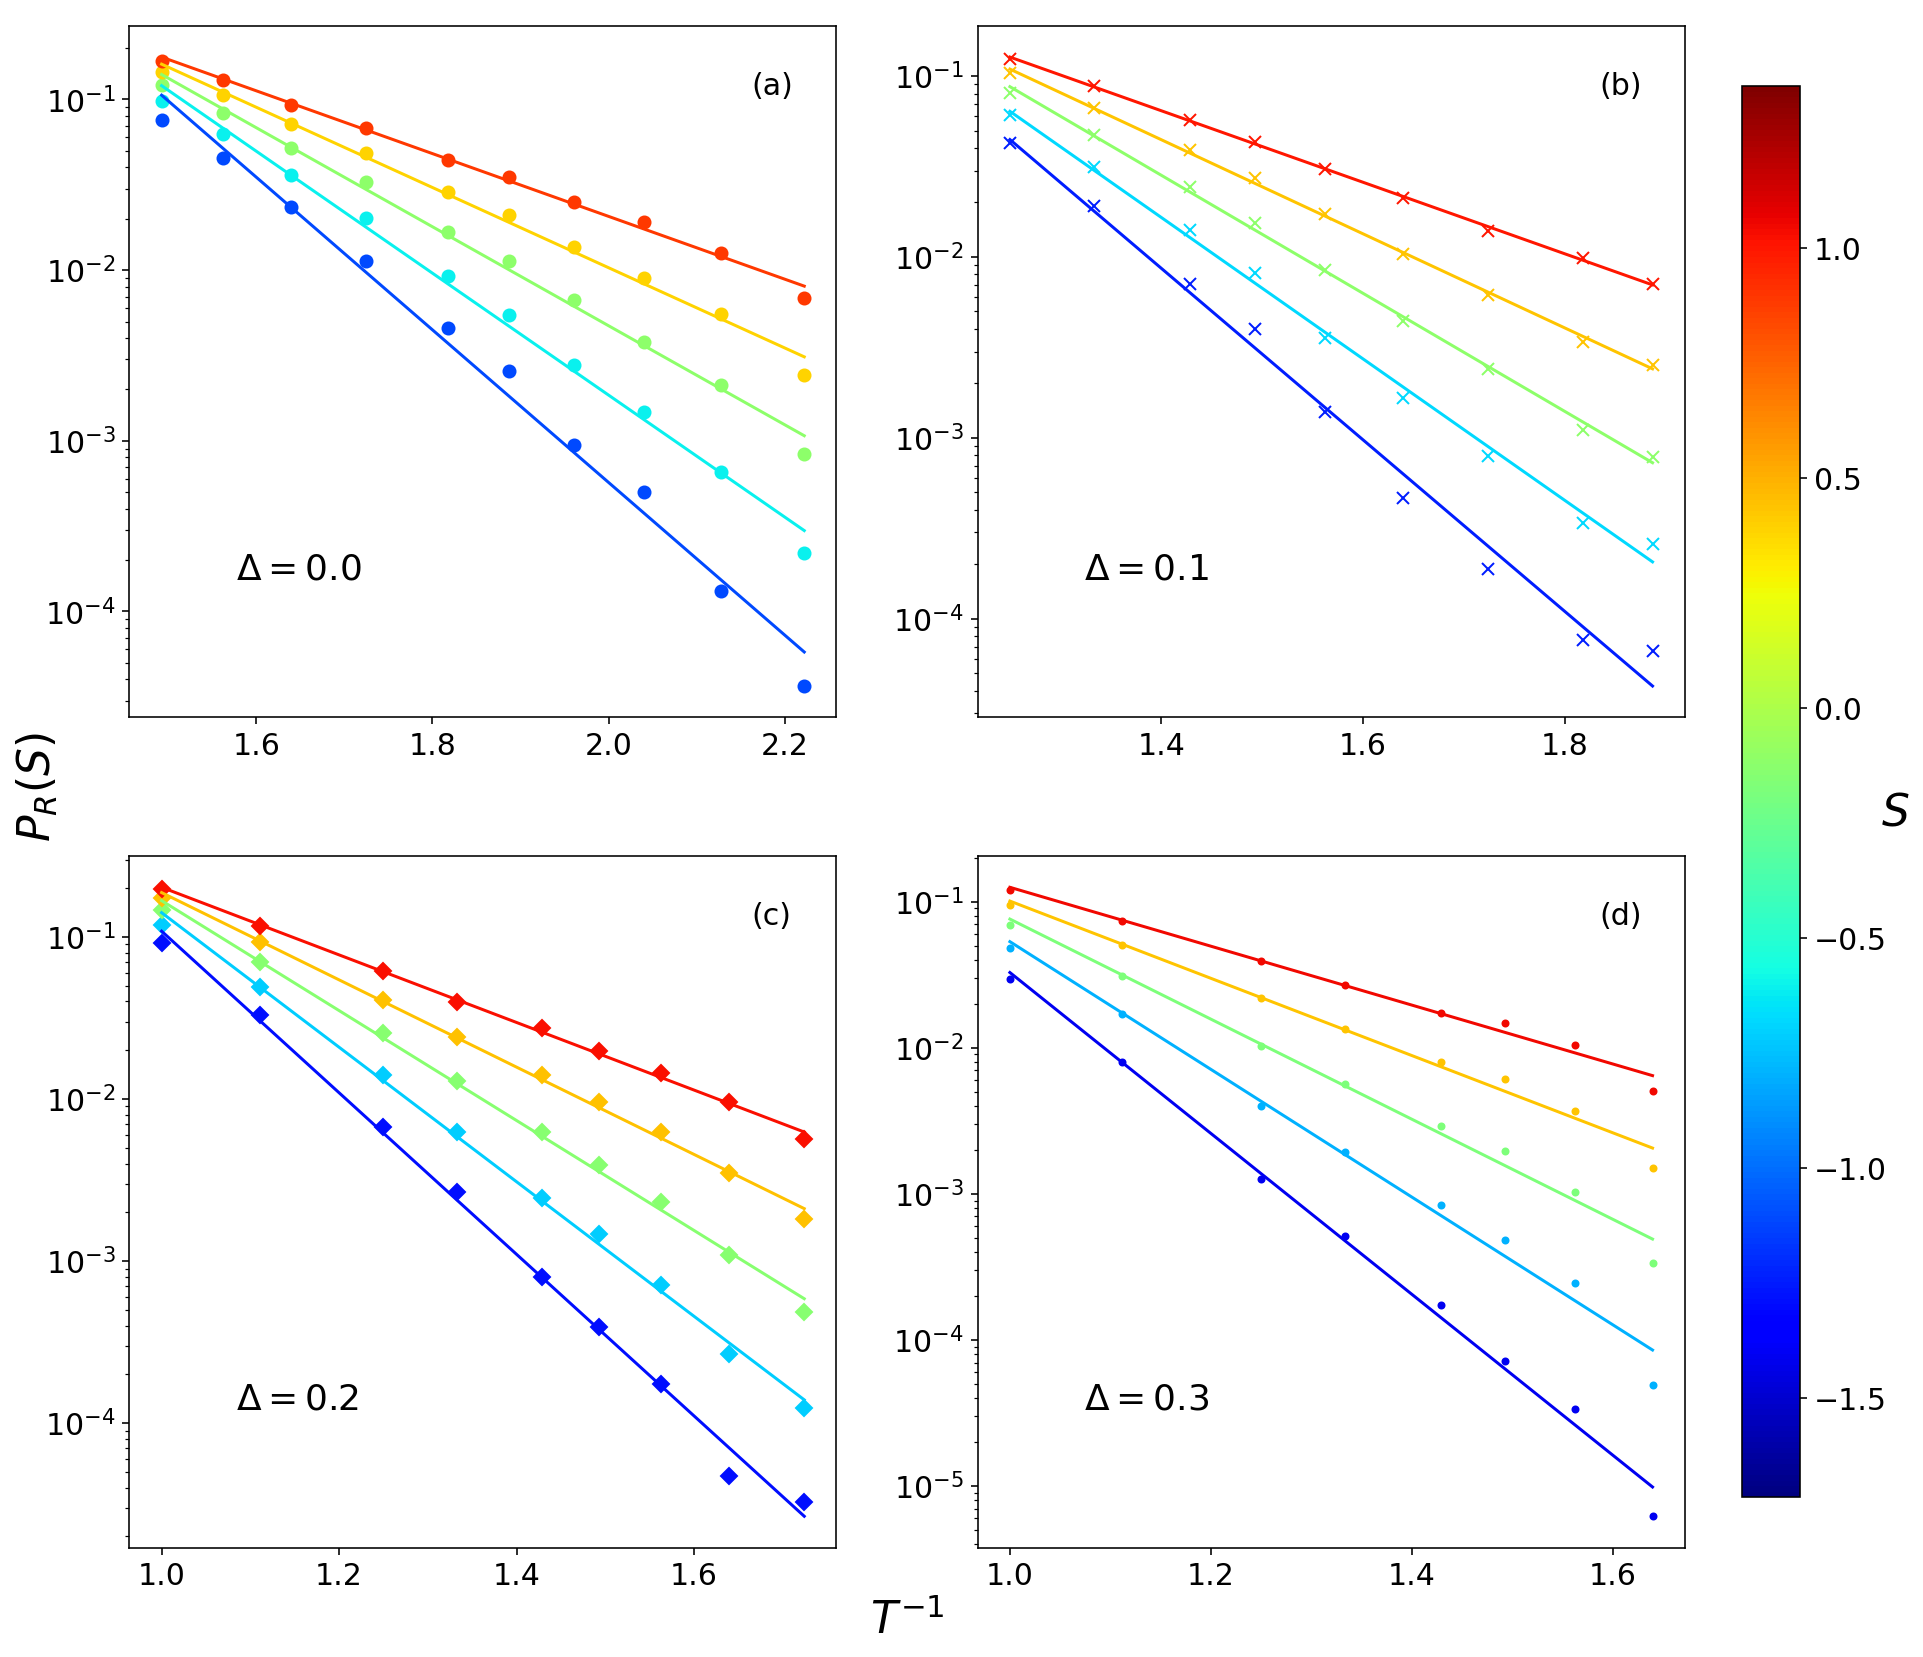

In [85]:
# make nice 4 bit plots

from collections import defaultdict

# q_min = -1.0
# q_max = 1.0

        
norm = colors.Normalize(vmin=q_min_all, vmax=q_max_all)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(16,14))
plt.ylabel(r"$P_R(S)$", fontsize=22)
plt.xlabel(r"$T^{-1}$", fontsize=22)
# ax0 = fig.add_subplot(111)    # The big subplot
ax0 = plt.gca()
ax0.spines['top'].set_color('none')
ax0.spines['bottom'].set_color('none')
ax0.spines['left'].set_color('none')
ax0.spines['right'].set_color('none')
ax0.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
axs = [ax1, ax2, ax3, ax4]

sub_labels = ["(a)", "(b)", "(c)", "(d)"]
deltas = [0.0, 0.1, 0.2, 0.3]


fit_output_data = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for system, marker, ax, sub_label, delta in zip(
                sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")),
                ('o', 'x', 'D', '.'),
                axs,
                sub_labels,
                deltas
            ):
        print(str(system))

        fit_data = defaultdict(list)
        coefs = []

        (qmin, qmax) = q_data[system]
        
        for temp in temps:
            if not temp_ok(system, temp, min_temp):
                continue
            if not max_temp_ok(system, temp, max_fit_temp):
                continue
                
            
                
            cuts = np.linspace(qmin, qmax,6)
            files = filter_chunks(system.glob(f"temp-{temp}_*"), 80)

            df = aggregate_parquet_dfs(files)
            df["cuts"] = pd.cut(df["softness"], cuts)

            gpby = df.groupby("cuts")

            new_df = gpby["rearrang"].mean()

            for i, rearrang in new_df.iteritems():
                ax.plot(1/temp, rearrang, marker, color=cmap(norm(i.mid)))
                fit_data[i.mid].append([1/temp, rearrang])
                
        fit_output_data.append(fit_data)

        for j, d in fit_data.items():
            d = np.array(d)
            coef = np.polyfit(d[:,0], np.log(d[:,1]), 1)
            tcoef = [j]
            tcoef.extend(list(coef))
            coefs.append(tcoef)
            y = np.exp(coef[1])*np.exp(coef[0]*d[:,0])
            ax.plot(d[:,0], y, color=cmap(norm(j)))
        ax.set_yscale('log')
        add_inner_plot_text(ax, sub_label)
        add_inner_plot_text(ax, fr"$\Delta={delta}$", x=0.15, y=0.2, fontsize="large")

# plt.yscale('log')

fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.825, 0.15, 0.025, 0.7])
cbar = fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label(label=r"$S$", fontsize=22, rotation=0)

/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05


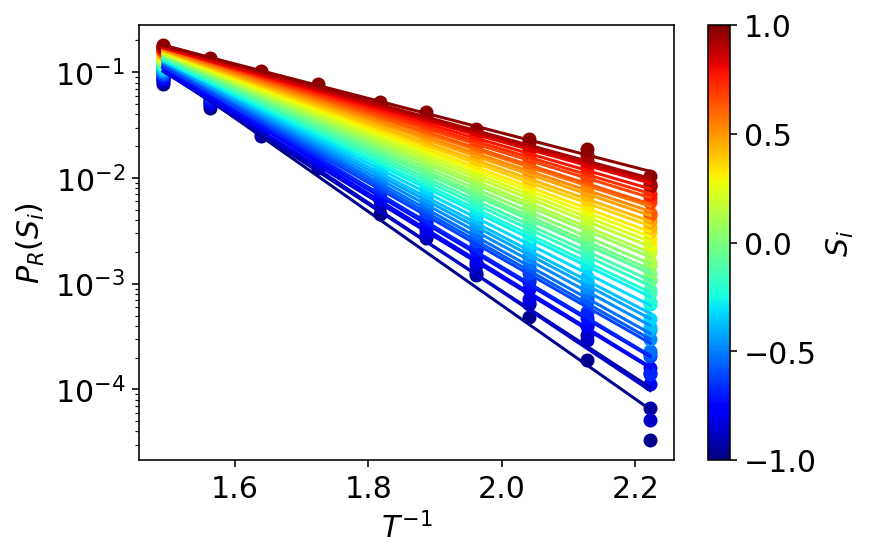

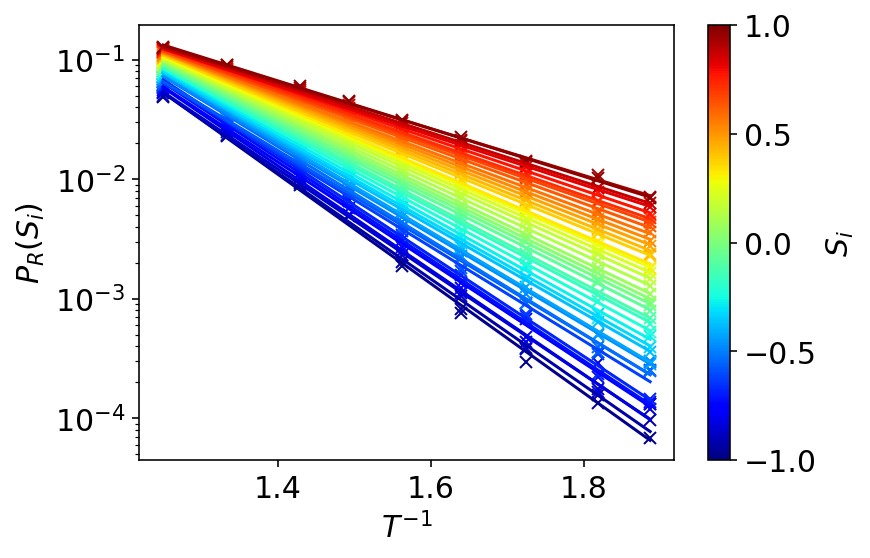

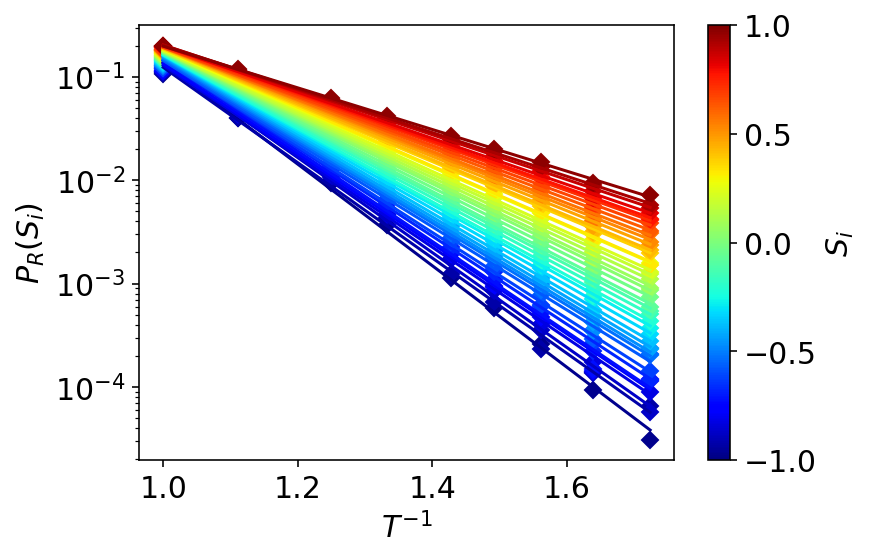

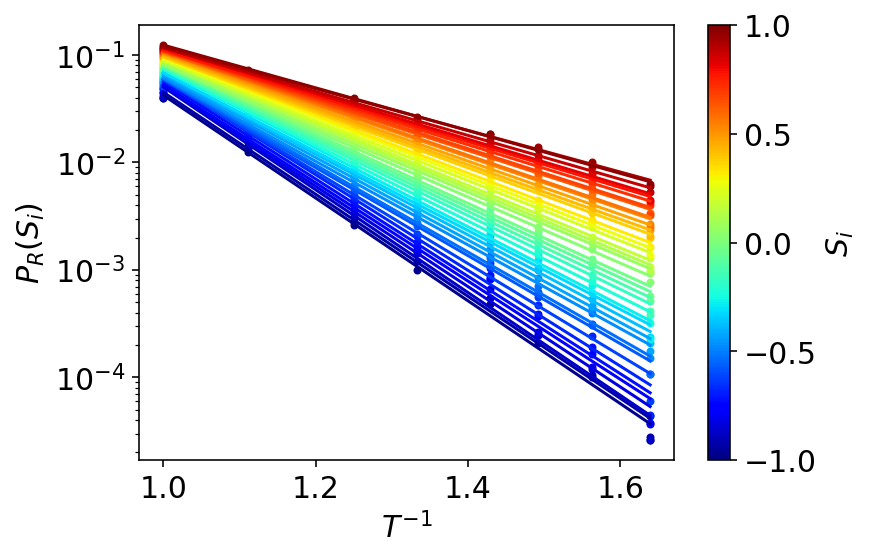

In [130]:
from collections import defaultdict

q_min = -1.0
q_max = 1.0

cuts = np.linspace(-1,1,41)        
norm = colors.Normalize(vmin=q_min, vmax=q_max)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

fit_output_data = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for system, marker in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.')):
        print(str(system))
        plt.figure()

        fit_data = defaultdict(list)
        coefs = []

        for temp in temps:
            if not temp_ok(system, temp, min_temp):
                continue
            if not max_temp_ok(system, temp, max_fit_temp):
                continue
            files = filter_chunks(system.glob(f"temp-{temp}_*"), 60)

            df = aggregate_parquet_dfs(files)
            df["cuts"] = pd.cut(df["softness"], cuts)

            gpby = df.groupby("cuts")

            new_df = gpby["rearrang"].mean()

            for i, rearrang in new_df.iteritems():
                plt.plot(1/temp, rearrang, marker, color=cmap(norm(i.mid)))
                fit_data[i.mid].append([1/temp, rearrang])
                
        fit_output_data.append(fit_data)

        for j, d in fit_data.items():
            d = np.array(d)
            coef = np.polyfit(d[:,0], np.log(d[:,1]), 1)
            tcoef = [j]
            tcoef.extend(list(coef))
            coefs.append(tcoef)
            y = np.exp(coef[1])*np.exp(coef[0]*d[:,0])
            plt.plot(d[:,0], y, color=cmap(norm(j)))

        plt.yscale('log')
        plt.ylabel(r"$P_R(S_{i})$")
        plt.xlabel(r"$T^{-1}$")
        plt.colorbar(sm, label=r"$S_{i}$")

/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_LJ_phi-1.2
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run1/pair-KA_ModLJ-0.1_phi-1.15
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.2_phi-1.1
/home/igraham/Data/funnel-cake/entr_soft_pub/final/softness/run2/pair-KA_ModLJ-0.3_phi-1.05


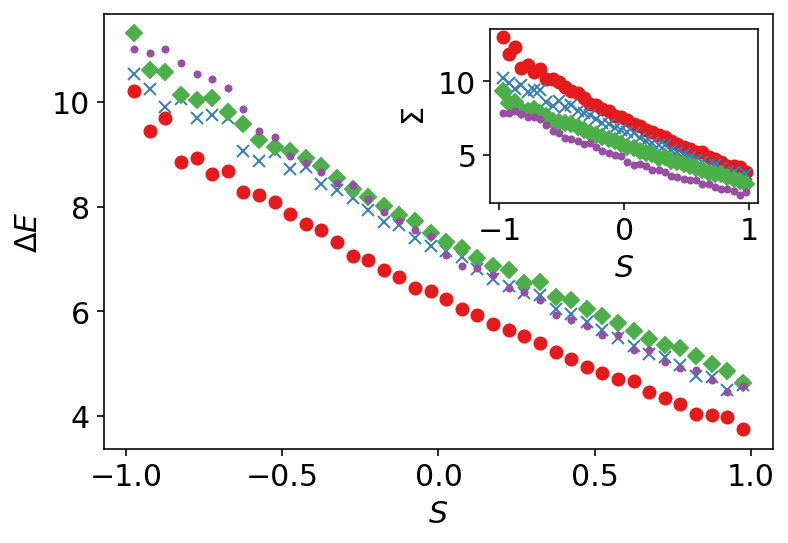

In [131]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    fig, ax = plt.subplots()
    
    ax2 = inset_axes(ax, width="40%", height="40%")
    
    axs = [ax, ax2]
    
    for system, marker, fit_data, c in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), fit_output_data, colorz):
        print(str(system))
        # plt.figure()

        for j, d in fit_data.items():
            d = np.array(d)
            coef = np.polyfit(d[:,0], np.log(d[:,1]), 1)
#             tcoef = [j]
#             tcoef.extend(list(coef))
#             coefs.append(tcoef)
#             y = np.exp(coef[1])*np.exp(coef[0]*d[:,0])
            axs[0].plot(j, -coef[0], marker=marker, color=c)
            axs[1].plot(j, coef[1], marker=marker, color=c)

    axs[0].set_ylabel(r"$\Delta E$")
    axs[0].set_xlabel(r"$S$")
    axs[1].set_ylabel(r"$\Sigma$")
    axs[1].set_xlabel(r"$S$")


In [ ]:
from collections import defaultdict

cuts = np.linspace(-1,1,41)        
norm = colors.Normalize(vmin=q_min, vmax=q_max)
cmap = cm.jet
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, axs = plt.subplots(2, 1figsize=(16,6))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    
    
    ax2 = inset_axes(ax, width="40%", height="40%")
    
    axs = [ax, ax2]
    break
    
    for system, marker, soft_s2s, fit_data, c in zip(sorted(data_dir.glob("funnel-cake/entr_soft_pub/final/softness/*/*")), ('o', 'x', 'D', '.'), soft_calc_s2s, fit_output_data, colorz):
        print(str(system))

        idx = 0
        for j, d in fit_data.items():
            d = np.array(d)
            coef = np.polyfit(d[:,0], np.log(d[:,1]), 1)
            axs[0].plot(soft_s2s[1][idx], -coef[0], marker=marker, color=c)
            axs[1].plot(soft_s2s[1][idx], coef[1], marker=marker, color=c)
            idx += 1

    axs[0].set_ylabel(r"$\Delta E$")
    axs[0].set_xlabel(r"$S_2$")
    axs[1].set_ylabel(r"$\Sigma$")
    axs[1].set_xlabel(r"$S_2$")
